## Library Imports

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
import shap
from lime.lime_tabular import LimeTabularExplainer

## Globals & Constants

In [277]:
sns.set_theme(style='whitegrid', font='consolas', palette='crest')
shap.initjs()

## Utility Functions

In [264]:
def clean_text(df: pd.DataFrame) -> None:
    object_cols = df.select_dtypes(include='object')

    df[object_cols.columns] = df[object_cols.columns].apply(lambda x: x.str.strip())

def dedupe(df: pd.DataFrame) -> None:
    before = len(df)
    df.drop_duplicates(inplace=True)
    
    print(f"Number Of Dropped Duplicates: {before - len(df)}")

def explore_numeric_cols(df: pd.DataFrame) -> None:
    numeric_cols = df.select_dtypes(exclude='object')

    display(numeric_cols.describe())

    figure, axes = plt.subplots(nrows=len(numeric_cols.columns), ncols=2, figsize=(10, 3 * len(numeric_cols.columns)))
    figure.subplots_adjust(hspace=0.4)

    for i, column in enumerate(numeric_cols.columns):
        sns.histplot(df[column], kde=True, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'{column} Distribution')
        
        sns.boxplot(x=df[column], ax=axes[i, 1], color='salmon')
        axes[i, 1].set_title(f'{column} Boxplot')

    plt.tight_layout()
    display(plt.show())

    display(sns.heatmap(numeric_cols.corr()))

def explore_object_cols(df: pd.DataFrame) -> None:
    object_cols = df.select_dtypes(include='object')

    display(object_cols.describe())
    
    for column in object_cols:
        print(f' {column} '.center(50, "="))

        modes = df[column].value_counts().nlargest(10)
        values = [str(value)[:30] + ('...' if len(str(value)) > 30 else '') for value in modes.index]

        for (value, mode) in zip(values, modes):
            print(f'{value:<40} {mode}')
        print()

def explore_na(df: pd.DataFrame) -> None:
    display(df.isnull().sum())
    display(msno.matrix(df))
    display(msno.dendrogram(df))

def evaluate_metrics(model, X_test, y_test) -> None:
    y_pred = (model.predict(X_test) >= 0.5).astype(int)

    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    display(plt.show())

    print(classification_report(y_test, y_pred))

## Data Processing

### Reviews Table Data Processing

#### Reviews Table Data Exploration

In [216]:
reviews_df = pd.read_csv('raw_dataset/AirlineScrappedReview_Cleaned.csv')

In [217]:
clean_text(reviews_df)
dedupe(reviews_df)

Number Of Dropped Duplicates: 74


In [218]:
display(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3501 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3500 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2807 non-null   object 
 3   Rating           3501 non-null   int64  
 4   Verified         3501 non-null   object 
 5   Review_title     3501 non-null   object 
 6   Review_content   3501 non-null   object 
 7   Traveller_Type   3501 non-null   object 
 8   Class            3501 non-null   object 
 9   Start_Location   2807 non-null   object 
 10  End_Location     2807 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3441 non-null   float64
 13  Start_Longitude  3441 non-null   float64
 14  Start_Address    3441 non-null   object 
 15  End_Latitude     3402 non-null   float64
 16  End_Longitude    3402 non-null   float64
 17  End_Address      34

None

- Column names do not look to follow a consistent case, with the second word not always being capitalized.
- Majority of the columns seem to be of type object.

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude
count,3501.000000,3441.000000,3441.000000,3402.000000,3402.000000
mean,4.764924,42.564281,-2.418618,40.429634,-1.353347
std,3.167312,17.193260,44.991376,18.904671,46.489936
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234
25%,2.000000,41.875562,-0.458780,38.954140,-0.458780
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765
75%,8.000000,51.467739,11.048029,51.467739,11.048029
max,10.000000,65.011873,151.208285,64.145981,174.550610


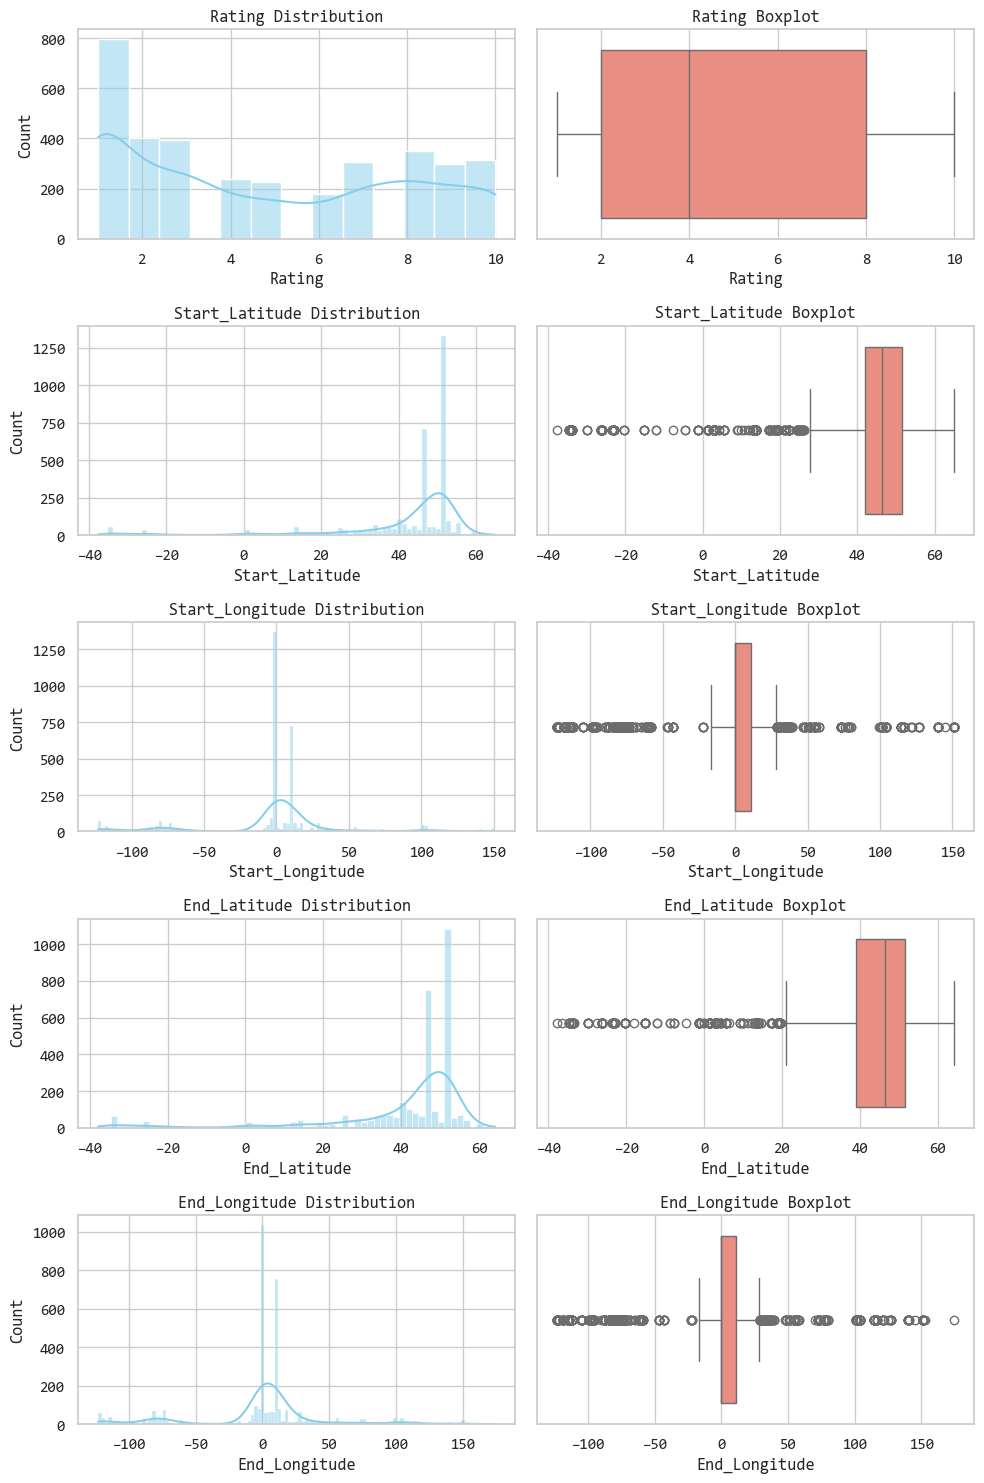

None

<Axes: >

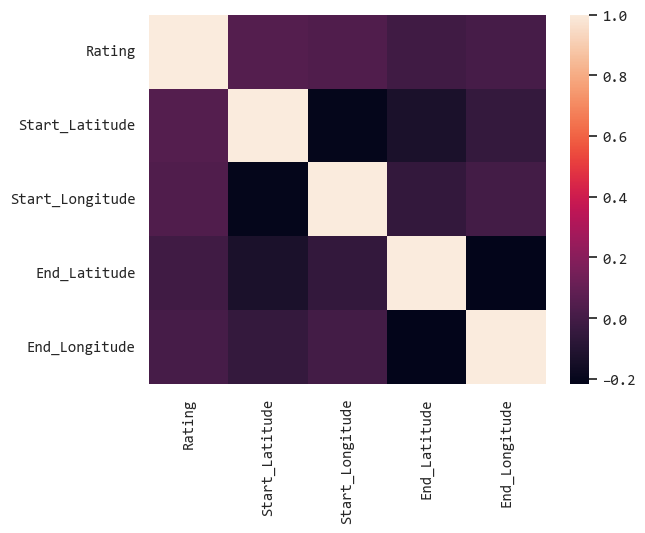

In [219]:
explore_numeric_cols(reviews_df)

In [220]:
explore_object_cols(reviews_df)

,Passanger_Name,Flying_Date,Route,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Address,End_Address
count,3500,955,2807,3501,3501,3501,3501,3501,2807,2807,484,3441,3402
unique,2759,100,1495,2,2567,3501,6,5,329,380,48,284,320
top,David Ellis,August 2015,London to Johannesburg,Not Verified,British Airways customer review,The airline lost my luggage and was absolutely...,Couple Leisure,Economy Class,London Heathrow,London Heathrow,London,"Nanno, Ville d'Anaunia, Comunità della Val di ...","Nanno, Ville d'Anaunia, Comunità della Val di ..."
freq,43,25,18,2434,875,1,947,1823,582,437,202,694,694


================= Passanger_Name =================
David Ellis                              43
Clive Drake                              32
E Smyth                                  29
R Vines                                  13
Mike Palmer                              12
Craig Cutts                              12
Richard Hodges                           11
Bob Motto                                11
Christopher Neep                         11
John Rolfe                               10

================== Flying_Date ===================
August 2015                              25
March 2023                               23
September 2015                           23
April 2017                               21
December 2016                            21
June 2017                                20
March 2018                               19
January 2017                             19
September 2017                           19
June 2022                                19

================

- Location columns have more unique values than address columns, which is highly abnormal.
- `Traveller_Type` has a notable amount of instances where it is set to "Unknkown", we might regard it as null.
- `Traveller_Type` has outlier value "Various" and `Class` has outlier value "Unknown".
- `Start_Address` and `End_Address` have the same mode address with the same frequency which is a bit suspicious.

#### Reviews Table Data Cleaning

Passanger_Name        1
Flying_Date        2546
Route               694
Rating                0
Verified              0
Review_title          0
Review_content        0
Traveller_Type      688
Class                 0
Start_Location      694
End_Location        694
Layover_Route      3017
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

<Axes: >

<Axes: >

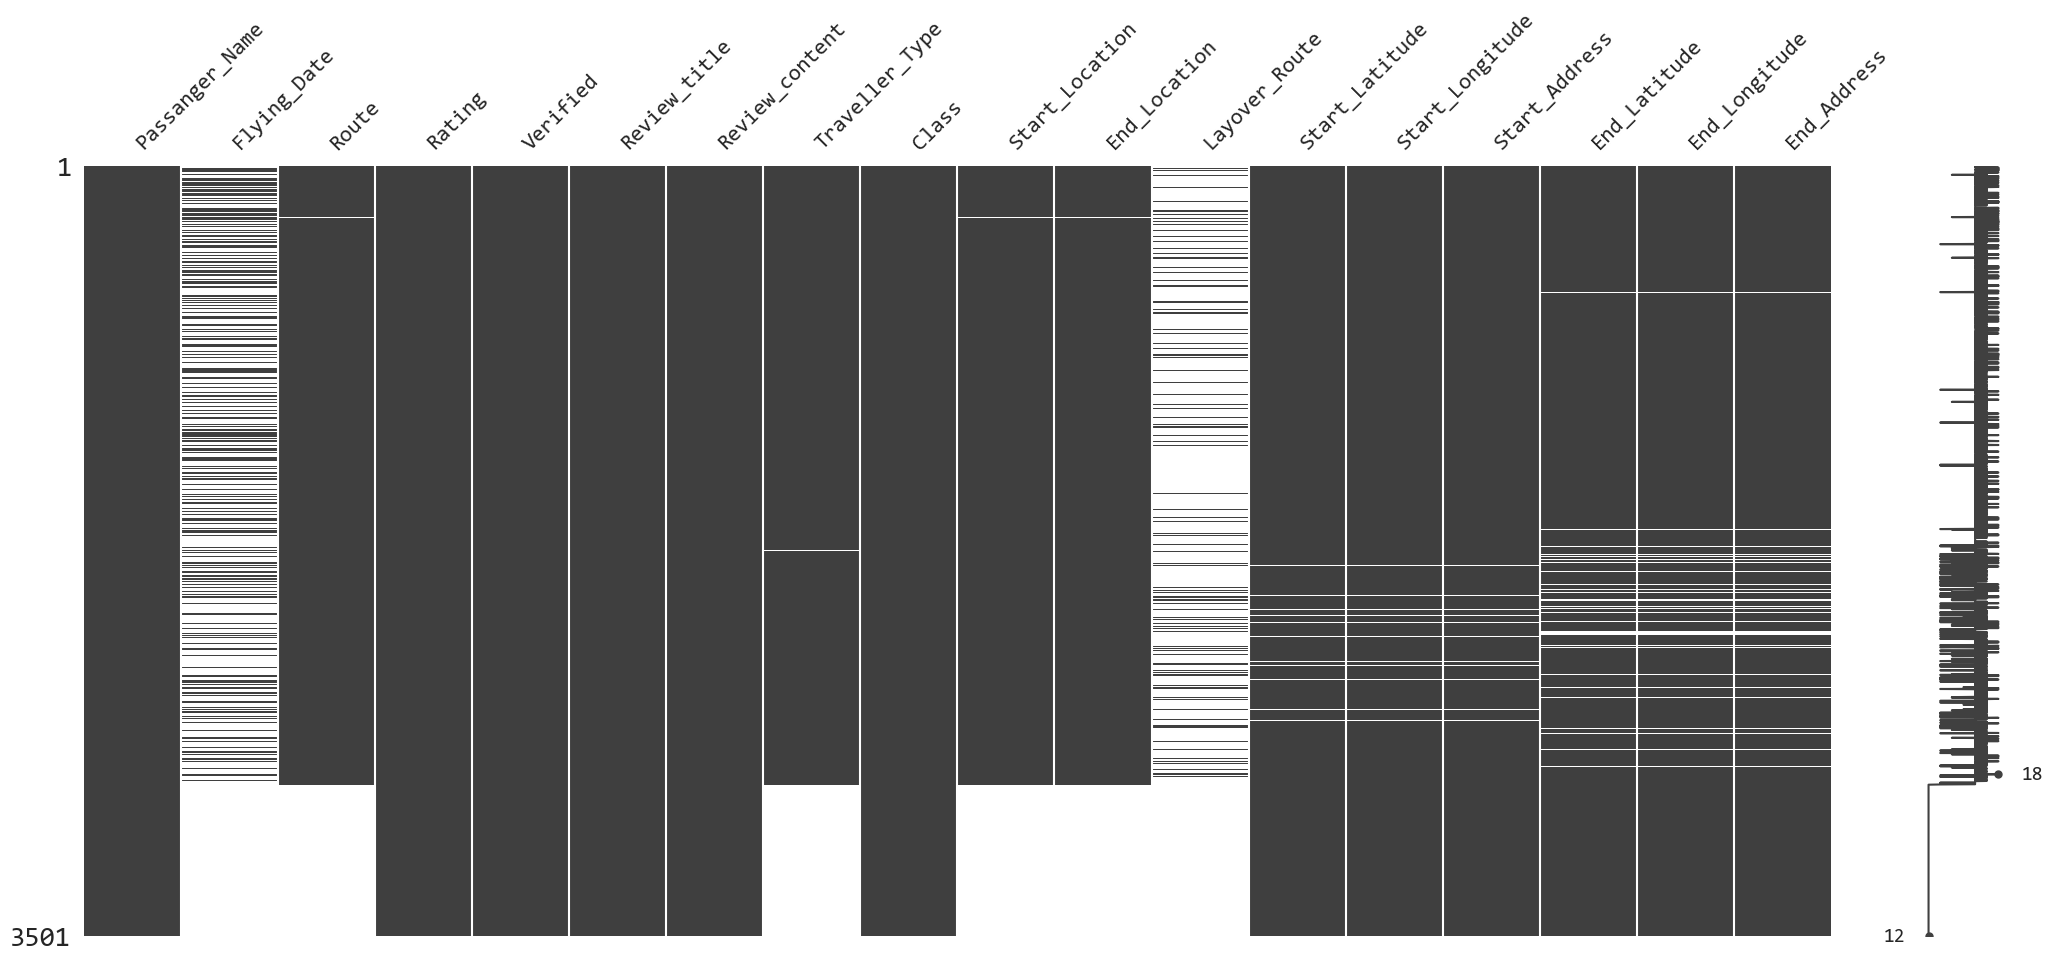

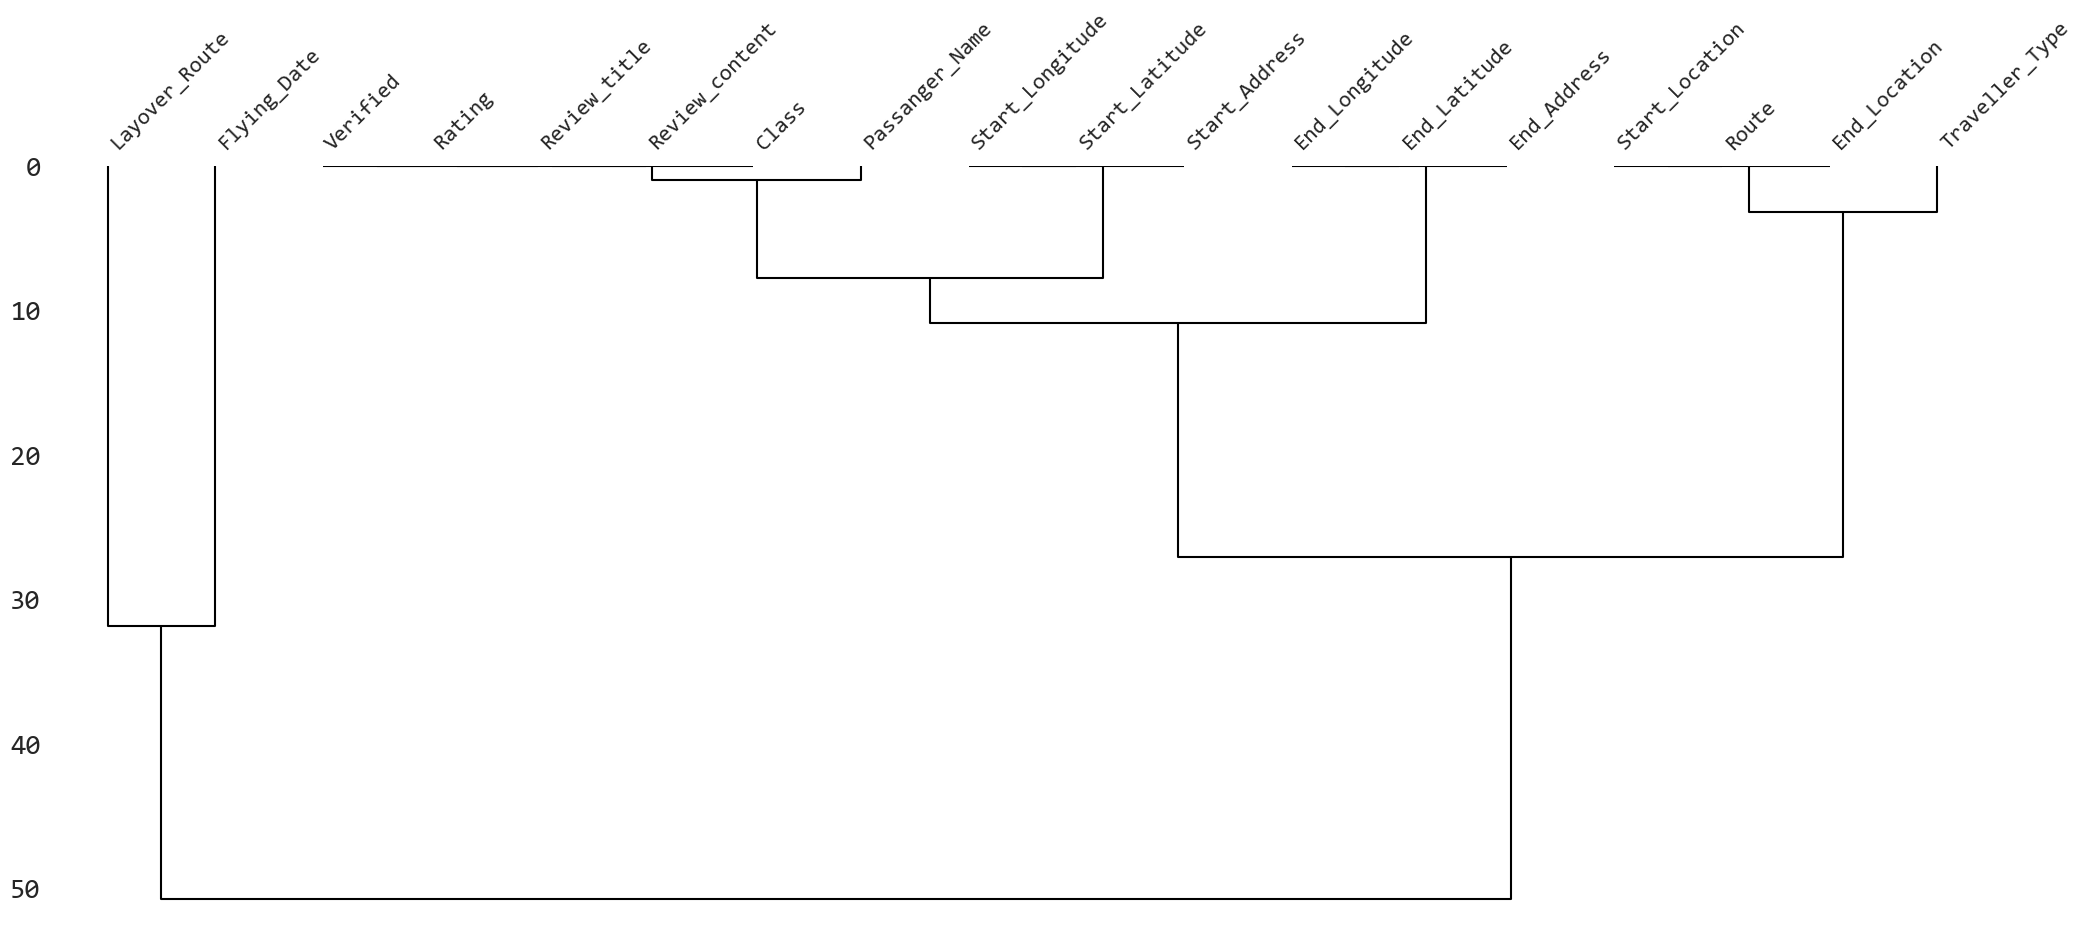

In [221]:
reviews_df.loc[reviews_df['Traveller_Type'] == 'Unknown', 'Traveller_Type'] = None

explore_na(reviews_df)

- `Flying_Date` and `Layover_Route` have a majority of null values.
- At a certain point, some specific columns start having null values regularly and systematically.
- Latiture, longitude and address can possibly be inferred from location.
- `Route` shares a gap with `Start_Location` and `End_Location`, can be filled if location can be derived from address.

In [222]:
reviews_df.drop(columns=['Flying_Date'], inplace=True)
reviews_df = reviews_df[(reviews_df['Traveller_Type'] != 'Various') & (reviews_df['Class'] != 'Unknown')]

- As the MSNO matrix shows, `Flying_Date` isn't redeemable as the significant majority of its values are null. It was dropped.
- Outlier values for `Traveller_Type` and `Various` were dropped due to their too insignificant counts.

In [223]:
reviews_df['Layover_Route'].fillna('direct', inplace=True)

C:\Users\Compumarts\AppData\Local\Temp\ipykernel_23932\3992992645.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reviews_df['Layover_Route'].fillna('direct', inplace=True)


- `Layover_Route`, on the other hand, makes sense to have null as the majority of its values so it was simply filled with "direct", meaning no transits.

In [224]:
sus_addr = reviews_df['Start_Address'].mode()[0]

sus_rows = reviews_df[reviews_df['Start_Address'] == sus_addr]
print(f'Number Of Suspicious Rows: {len(sus_rows)}')

idle_flights = reviews_df[reviews_df['Start_Address'] == reviews_df['End_Address']]
print(f'Number Of Idle Flights: {len(sus_rows)}')

sus_idle_flights = pd.merge(sus_rows, idle_flights, how='inner')
print(f'Number Of Suspicious Idle Flights: {len(sus_idle_flights)}')

reviews_df = reviews_df[reviews_df['Start_Address'] != sus_addr]


Number Of Suspicious Rows: 693
Number Of Idle Flights: 693
Number Of Suspicious Idle Flights: 693


- It was decided to drop the rows that contain the anomalous address as it is illogical to have the same origin and destination for a flight.

In [225]:
max_loc_addr = reviews_df.groupby('Start_Location')['Start_Address'].nunique().max()
print(f'Maximum Number Of Unique Addresses Assigned To A Unique Location: {max_loc_addr}')

max_addr_loc = reviews_df.groupby('Start_Address')['Start_Location'].nunique().max()
print(f'Maximum Number Of Unique Locations Assigned To A Unique Address: {max_addr_loc}')

addr_loc = reviews_df.groupby('Start_Address')['Start_Location'].agg(lambda x: list(set(x))).reset_index().assign(count=lambda x: x.Start_Location.str.len()).sort_values('count', ascending=False)
display(addr_loc.head(10))

loc_diff = set(reviews_df['Start_Location']).symmetric_difference(set(reviews_df['End_Location']))
print(f'Number Of Locations That Are Only Either Start Or End: {len(loc_diff)}')

start_loc_map = (reviews_df.groupby('Start_Address')['Start_Location'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None))
reviews_df['Start_Location'] = reviews_df['Start_Address'].map(start_loc_map)

end_loc_map = (reviews_df.groupby('End_Address')['End_Location'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None))
reviews_df['End_Location'] = reviews_df['End_Address'].map(end_loc_map)

Maximum Number Of Unique Addresses Assigned To A Unique Location: 1
Maximum Number Of Unique Locations Assigned To A Unique Address: 3


,Start_Address,Start_Location,count
192,"San Jose, Santa Clara County, California, Unit...","[San Jose, CA, San Jose, San Jose (CA)]",3
252,"الدوحة, قطر","[Doha, doha]",2
129,"London Gatwick Airport, Perimeter Road East, L...","[London LGW, London Gatwick]",2
62,"Dallas/Fort Worth International Airport, 2400,...","[Dallas Ft Worth, Dallas Fort-Worth]",2
85,George Bush Intercontinental Airport - Houston...,"[iAH, Houston, TX - George Bush Intercontinent...",2
109,"John F. Kennedy International Airport, JFK Acc...","[New York JFK, New York - John F. Kennedy (NY)]",2
28,"Belfast, County Antrim, Northern Ireland / Tua...","[Belfast City, Belfast]",2
122,"Leeds Bradford Airport, Scotland Lane, Moor Si...","[Leeds Bradford, Leeds/Bradford]",2
100,"Hewanorra International Airport, New Dock Road...","[UVF, St. Lucia Hewanorra]",2
260,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...","[Amman, Amman Jordan]",2


Number Of Locations That Are Only Either Start Or End: 187


- Upon inspection of the abnormal difference in the number of unique values between locations and addresses, it was discovered that their relationship is many:1 instead of 1:many.
- Further investigation uncovered that this inaccuracy is attributed to the fact that a single location can appear in the form of multiple variants throught the table.
- This has been corrected by assigning all addresses that belong to any variants of a particular location to the most repeated variant of that location.
- Can not only depend on either start or end, must depend on both as their set difference isn't empty. So, a separate map was created for both start and end.
- - -
- The selected variant is rather a local mode than a global mode.
- The only way to implement a solution with the much more accruate global mode will be to link all variants togther to the most repeated variant, which requires a complex solution that we reckon exceeds the scope of the current task.
- **MAYBE** Investigate if this complex soultion can be dropped in favor of depending on another column like `Route` for example, if possible.

In [226]:
na_start_addr = reviews_df[reviews_df['Start_Address'].isna()]
print('Null Start Addresses:')
display(na_start_addr.head(5))

na_end_addr = reviews_df[reviews_df['End_Address'].isna()]
print('Null End Addresses:')
display(na_end_addr.head(5))

infer_start_addr = na_start_addr['Start_Location'].isin(reviews_df[~reviews_df['Start_Address'].isna()]['Start_Location'])
print(f'Number Of Inferable Start Addresses From Start Locations: {infer_start_addr.sum()}')

infer_end_addr = na_end_addr['End_Location'].isin(reviews_df[~reviews_df['End_Address'].isna()]['End_Location'])
print(f'Number Of Inferable End Addresses From End Locations: {infer_end_addr.sum()}')

reviews_df.dropna(subset=['Start_Address', 'End_Address'], inplace=True)

Null Start Addresses:


,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
1019,Roger Stone,HKG to LHR,8,Trip Verified,an enjoyable experience,I thought it time BA deserved some compliments...,Business,Premium Economy,NaN,London Heathrow,direct,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro..."
1168,Carlos Arenas,Edimbourgh to London Gatwick,3,Trip Verified,I end up with mix feelings,I have traveled several times with British Air...,Couple Leisure,Economy Class,NaN,London Gatwick,direct,NaN,NaN,NaN,51.154108,-0.182312,"London Gatwick Airport, Perimeter Road East, L..."
1360,John Barry,Zakinthos to London Heathrow,8,Not Verified,very good flight again,Verified Review Zakinthos to London Heathrow...,Family Leisure,Business Class,NaN,London Heathrow,direct,NaN,NaN,NaN,51.467739,-0.458780,"London Heathrow Airport, Northern Perimeter Ro..."
1737,Vincent Borlaug,IAD to BCN via LHR,10,Not Verified,still my first choice,Verified Review Washington to Barcelona retu...,Solo Leisure,Premium Economy,NaN,Barcelona,London - Heathrow,NaN,NaN,NaN,41.382894,2.177432,"Barcelona, Barcelonès, Barcelona, Catalunya, 0..."
1749,J Hicklin,SFO to JNB via LHR,6,Not Verified,as different as night and day,Verified Review San Francisco to Johannesbur...,Solo Leisure,Business Class,NaN,Johannesburg - OR Tambo International Airport,London - Heathrow,NaN,NaN,NaN,-26.136013,28.244977,"O.R. Tambo International Airport, Elgin Street..."


Null End Addresses:


,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
357,J Prescott,Dubai to London Heaathrow,6,Trip Verified,just used the new Club World,We've just used the new Club World for the fir...,Couple Leisure,Business Class,Dubai,NaN,direct,25.265347,55.292491,"دبي, الإمارات العربية المتحدة",NaN,NaN,NaN
575,A Maharif,doha to londonDoha to London,9,Trip Verified,Surprisingly good flight,"Doha to London. Surprisingly good flight, onti...",Family Leisure,Economy Class,Doha,NaN,direct,25.285633,51.526416,"الدوحة, قطر",NaN,NaN,NaN
1074,Wolfgang Bernhart,Frankfurt to London Cuty,1,Trip Verified,There is not a hotline,When I checked in the evening before for the 7...,Business,Economy Class,Frankfurt,NaN,direct,50.110644,8.682092,"Frankfurt am Main, Hessen, Deutschland",NaN,NaN,NaN
1363,John Barry,London Heathrow to Zakinthos,9,Not Verified,kind and chatty with us,Verified Review London Heathrow to Zakinthos...,Family Leisure,Business Class,London Heathrow,NaN,direct,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN
1652,Ron Baker,LHR to GVA,2,Not Verified,not what one expects from Business Class,Verified Review Flew from London Heathrow to...,Couple Leisure,Business Class,London Heathrow,NaN,direct,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",NaN,NaN,NaN


Number Of Inferable Start Addresses From Start Locations: 0
Number Of Inferable End Addresses From End Locations: 0


- We have three ways to deal with a missing addresses:
  - Derive it from location.
  - Set it to location.
  - Drop it.
- - -
- We aim to exploit the assumed to exist 1:many relationship between `Start_Location` and `Start_Address` because logically, the latter should imply the former.
- This was a failed attempt to infer `Start_Address` from `Start_Location` as null addresses' locations do not have other non-null addresses.
- - -
- The tables demonstrate that the lack of addresses is sometimes attributed to a typo in specifying the locations.
- **UNSURE** It would be unwise to impute the latitude and longitudes according to a global statistic and not something local to for ex. location, which unfortunately lacks non-null replacements for null addresses / latitiudes / logitudes.
- Very little can be done to resolve that without the aid of something like an LLM, but we reckon that exceeds the scope of this task.
- - -
- It was decided to drop the missing addresses due to their insignificant count, in order to ensure data availability across all columns. Filling it with the locations' values felt like it was going to undermine the already existing addresses.
- **UNSURE** A small part of the data size was sacrificed for overall data completeness.

In [227]:
first_word_mode = reviews_df['Review_content'].str.split().str[0].mode()[0]
print(f'Most Repeated First Word In Reviews: {first_word_mode}')

reviews_df.loc[reviews_df['Review_content'].str.startswith('Verified Review   '), 'Verified'] = 'Trip Verified'
reviews_df.loc[reviews_df['Review_content'].str.match(r'^❎(?: Unverified)?   '), 'Verified'] = 'Not Verified'

reviews_df['Review_content'] = reviews_df['Review_content'].str.replace(r'^(?:Verified Review|❎(?: Unverified)?)   ', '', regex=True)

Most Repeated First Word In Reviews: Verified


- The mode first word in `Review_content` indicates possible column interference and upon further exploration of the data, it was confirmed that the column indeed somestimes does include data rather meant for the `Verified` column.

Passanger_Name     0
Route              0
Rating             0
Verified           0
Review_title       0
Review_content     0
Traveller_Type     2
Class              0
Start_Location     0
End_Location       0
Layover_Route      0
Start_Latitude     0
Start_Longitude    0
Start_Address      0
End_Latitude       0
End_Longitude      0
End_Address        0
dtype: int64

<Axes: >

<Axes: >

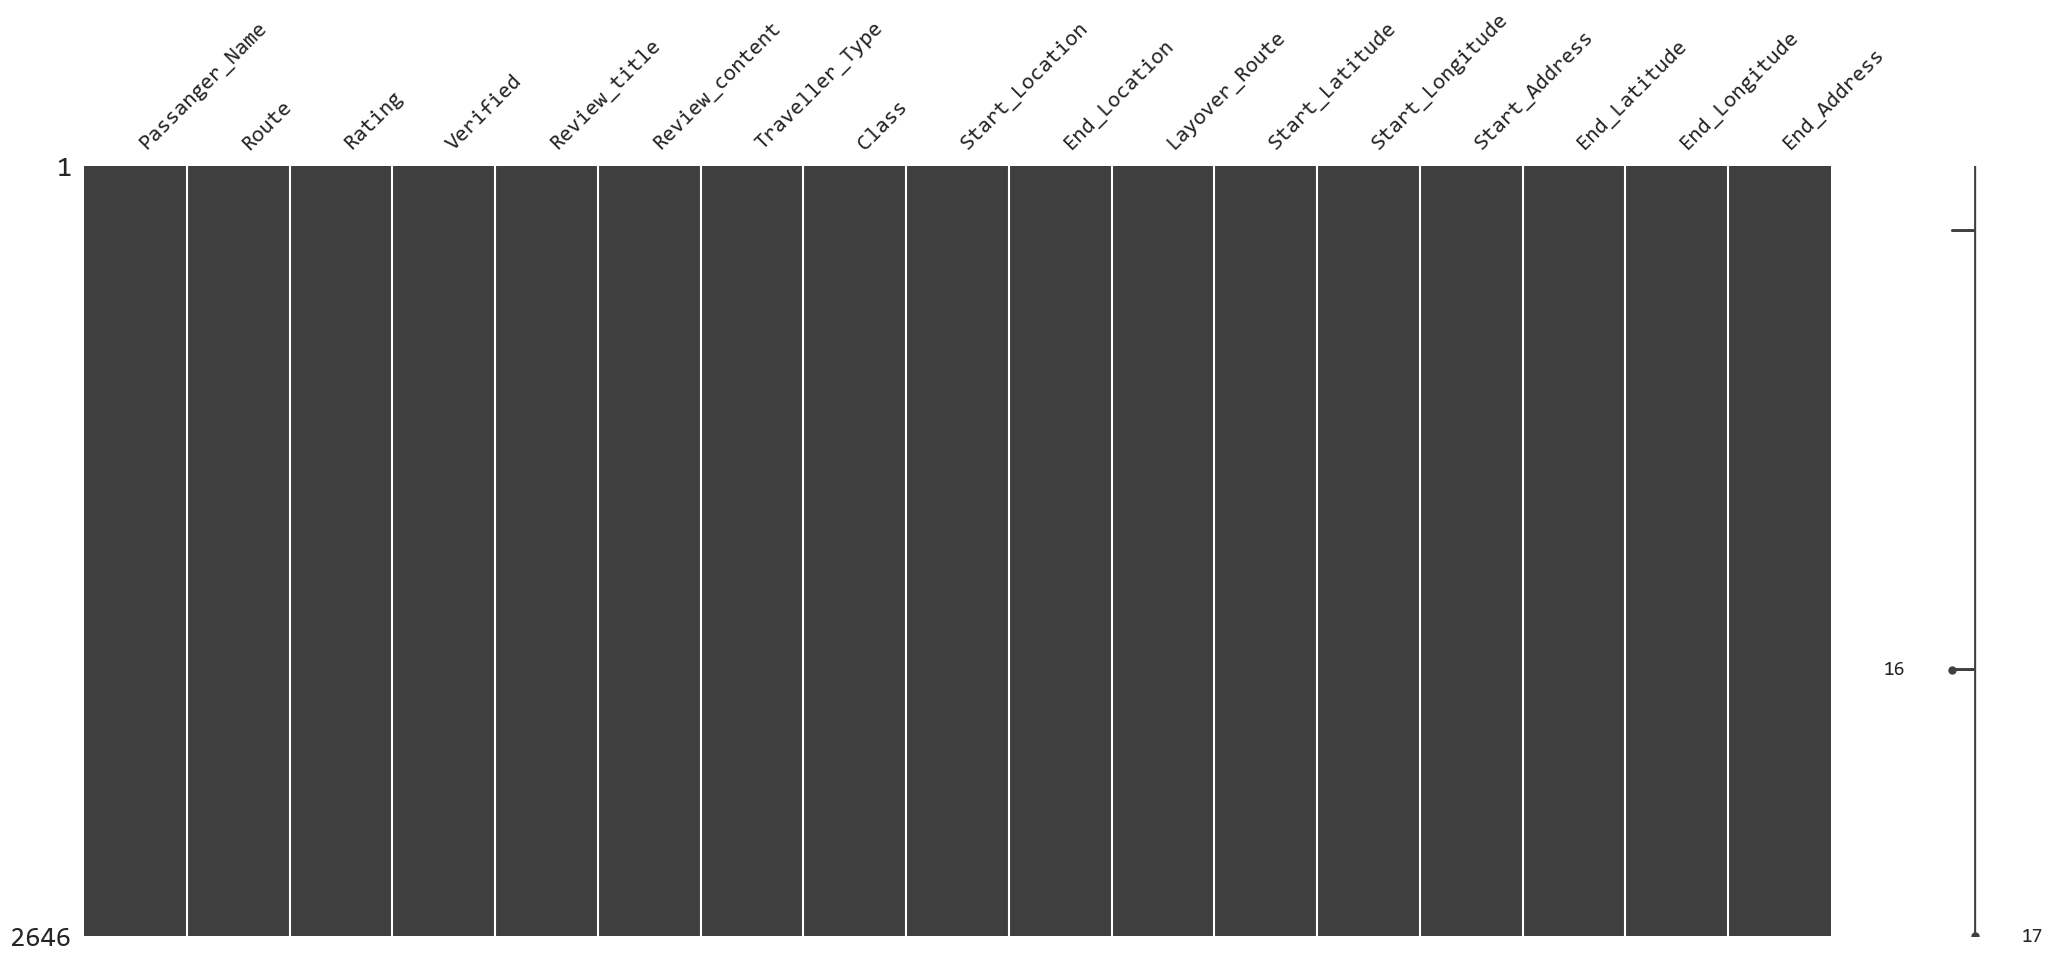

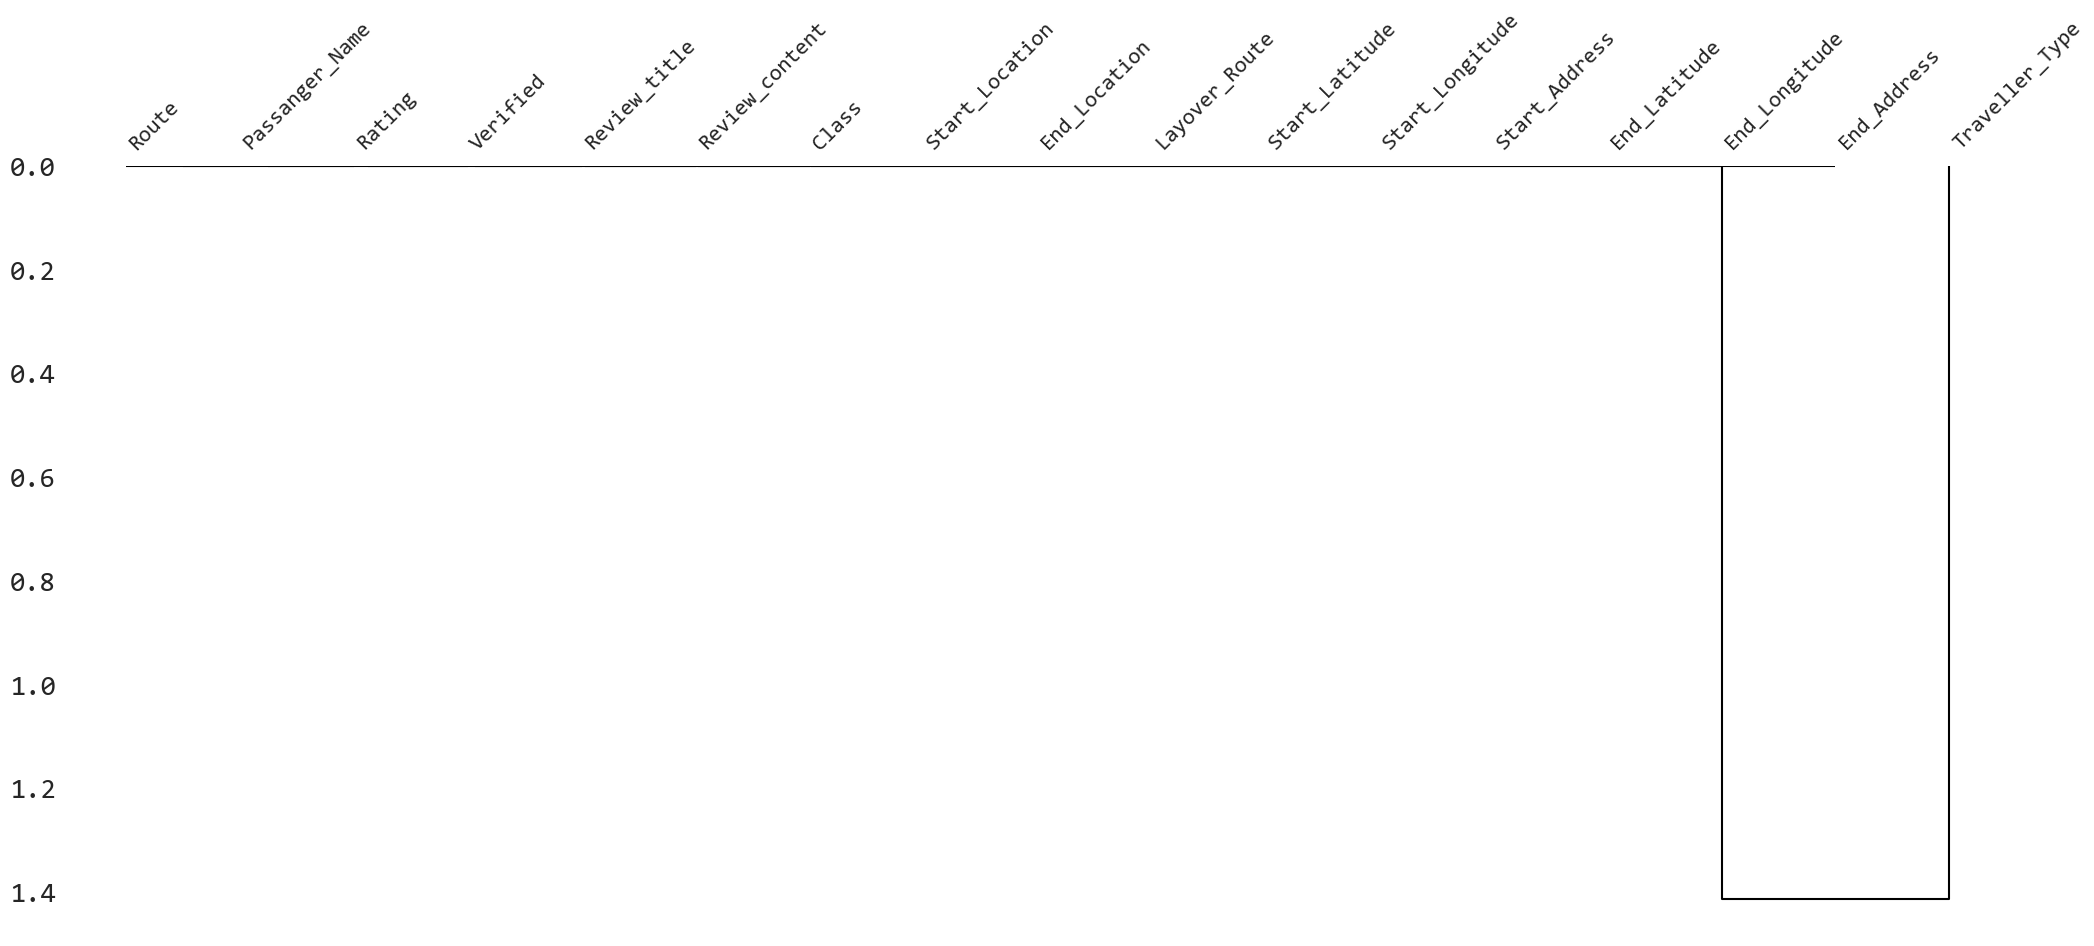

In [228]:
explore_na(reviews_df)

- The row lacking the `Passanger_Name` field is no longer present.
- Only two instaces of a null `Traveller_Type` remain.
- The gap shared between `Route`, `Start_Location` and `End_Location` is no longer present. We no longer need to attempt to derive location from address.
- These effects were observed after the removal operations concerning the anomalous address repeating plus the missing addresses.

In [229]:
reviews_df.dropna(subset=['Traveller_Type'], inplace=True)

- It was decided to drop the missing `Traveller_Type` instances due to their very insignificant count, in order to ensure data availability across all columns.

In [230]:
reviews_df.rename(columns={
    'Passanger_Name': 'passenger_name',
    'Route': 'route',
    'Rating': 'rating',
    'Verified': 'verified',
    'Review_title': 'review_title',
    'Review_content': 'review_content',
    'Traveller_Type': 'traveller_type',
    'Class': 'class',
    'Start_Location': 'start_location',
    'End_Location': 'end_location',
    'Layover_Route': 'layover_route',
    'Start_Latitude': 'start_latitude',
    'Start_Longitude': 'start_longitude',
    'Start_Address': 'start_address',
    'End_Latitude': 'end_latitude',
    'End_Longitude': 'end_longitude',
    'End_Address': 'end_address'
}, inplace=True)

- Column names were changed to use a more consistent and conventional case.

#### Reviews Table Feature Engineering

In [231]:
sentiment_analyzer = SentimentIntensityAnalyzer()
reviews_df['sentiment'] = reviews_df['review_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

display(reviews_df['sentiment'].describe())

count    2644.000000
mean        0.115838
std         0.782095
min        -0.997500
25%        -0.764700
50%         0.332600
75%         0.914325
max         0.999200
Name: sentiment, dtype: float64

In [232]:
# reviews_df.to_csv('processed_dataset/airline_reviews.csv', index=False)

### Comments Table Data Processing

#### Comments Table Data Exploration

In [233]:
comments_df = pd.read_csv('raw_dataset/Customer_comment.csv')

In [234]:
clean_text(reviews_df)
dedupe(comments_df)

Number Of Dropped Duplicates: 0


In [235]:
display(comments_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

None

- The first column lacks a name.
- The majority of the columns are of type object, all except one.

,Unnamed: 0,flight_number
count,9424.000000,9424.000000
mean,4711.500000,1741.573430
std,2720.618802,1550.550037
min,0.000000,2.000000
25%,2355.750000,614.000000
50%,4711.500000,1286.000000
75%,7067.250000,2261.000000
max,9423.000000,6375.000000


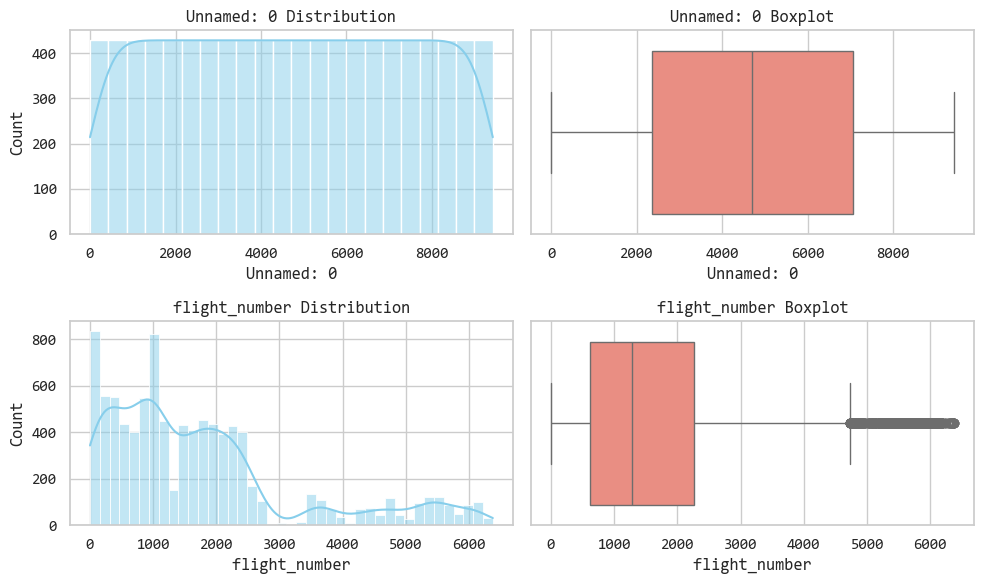

None

<Axes: >

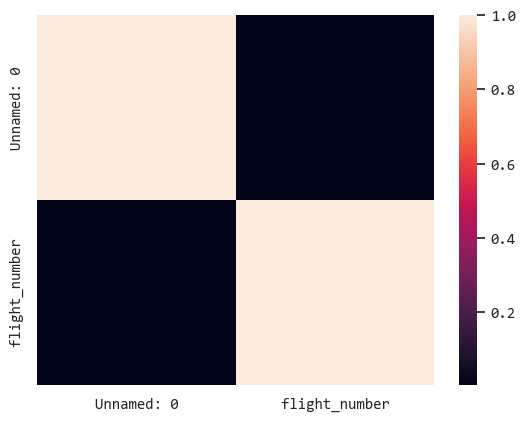

In [236]:
explore_numeric_cols(comments_df)

In [237]:
explore_object_cols(comments_df)

,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group,sentiments,transformed_text
count,9424,9424,9424,9424,9424,9424,9424,9424,9424,6920,9424,9424,9424,9424,8405
unique,195,192,30,2,2,4,8013,4,1,7,22,2,3,2,7609
top,IAX,IAX,2022-09-10,Early & Ontime,Early & Ontime,Domestic,No.,90+,Is there anything else you'd like to share abo...,non-elite,B737-900,Mainline,member,Neutral,none
freq,1149,1427,399,6811,6241,6593,774,6302,9424,4128,1451,7985,6905,9307,97


============== origin_station_code ===============
IAX                                      1149
EWX                                      1009
DEX                                      942
ORX                                      893
SFX                                      720
LAX                                      407
LHX                                      247
HNX                                      150
SAX                                      146
BOX                                      146

============ destination_station_code ============
IAX                                      1427
EWX                                      1210
ORX                                      947
DEX                                      872
SFX                                      768
LAX                                      443
LHX                                      179
HNX                                      148
MCX                                      137
SAX                                   

- `ques_verbatim_text` has one single value.
- `loyalty_program_level` and `response_group` have outlier value "NBK".

Unnamed: 0                     0
flight_number                  0
origin_station_code            0
destination_station_code       0
scheduled_departure_date       0
arrival_delay_group            0
departure_delay_group          0
entity                         0
verbatim_text                  0
seat_factor_band               0
ques_verbatim_text             0
loyalty_program_level       2504
fleet_type_description         0
fleet_usage                    0
response_group                 0
sentiments                     0
transformed_text            1019
dtype: int64

<Axes: >

<Axes: >

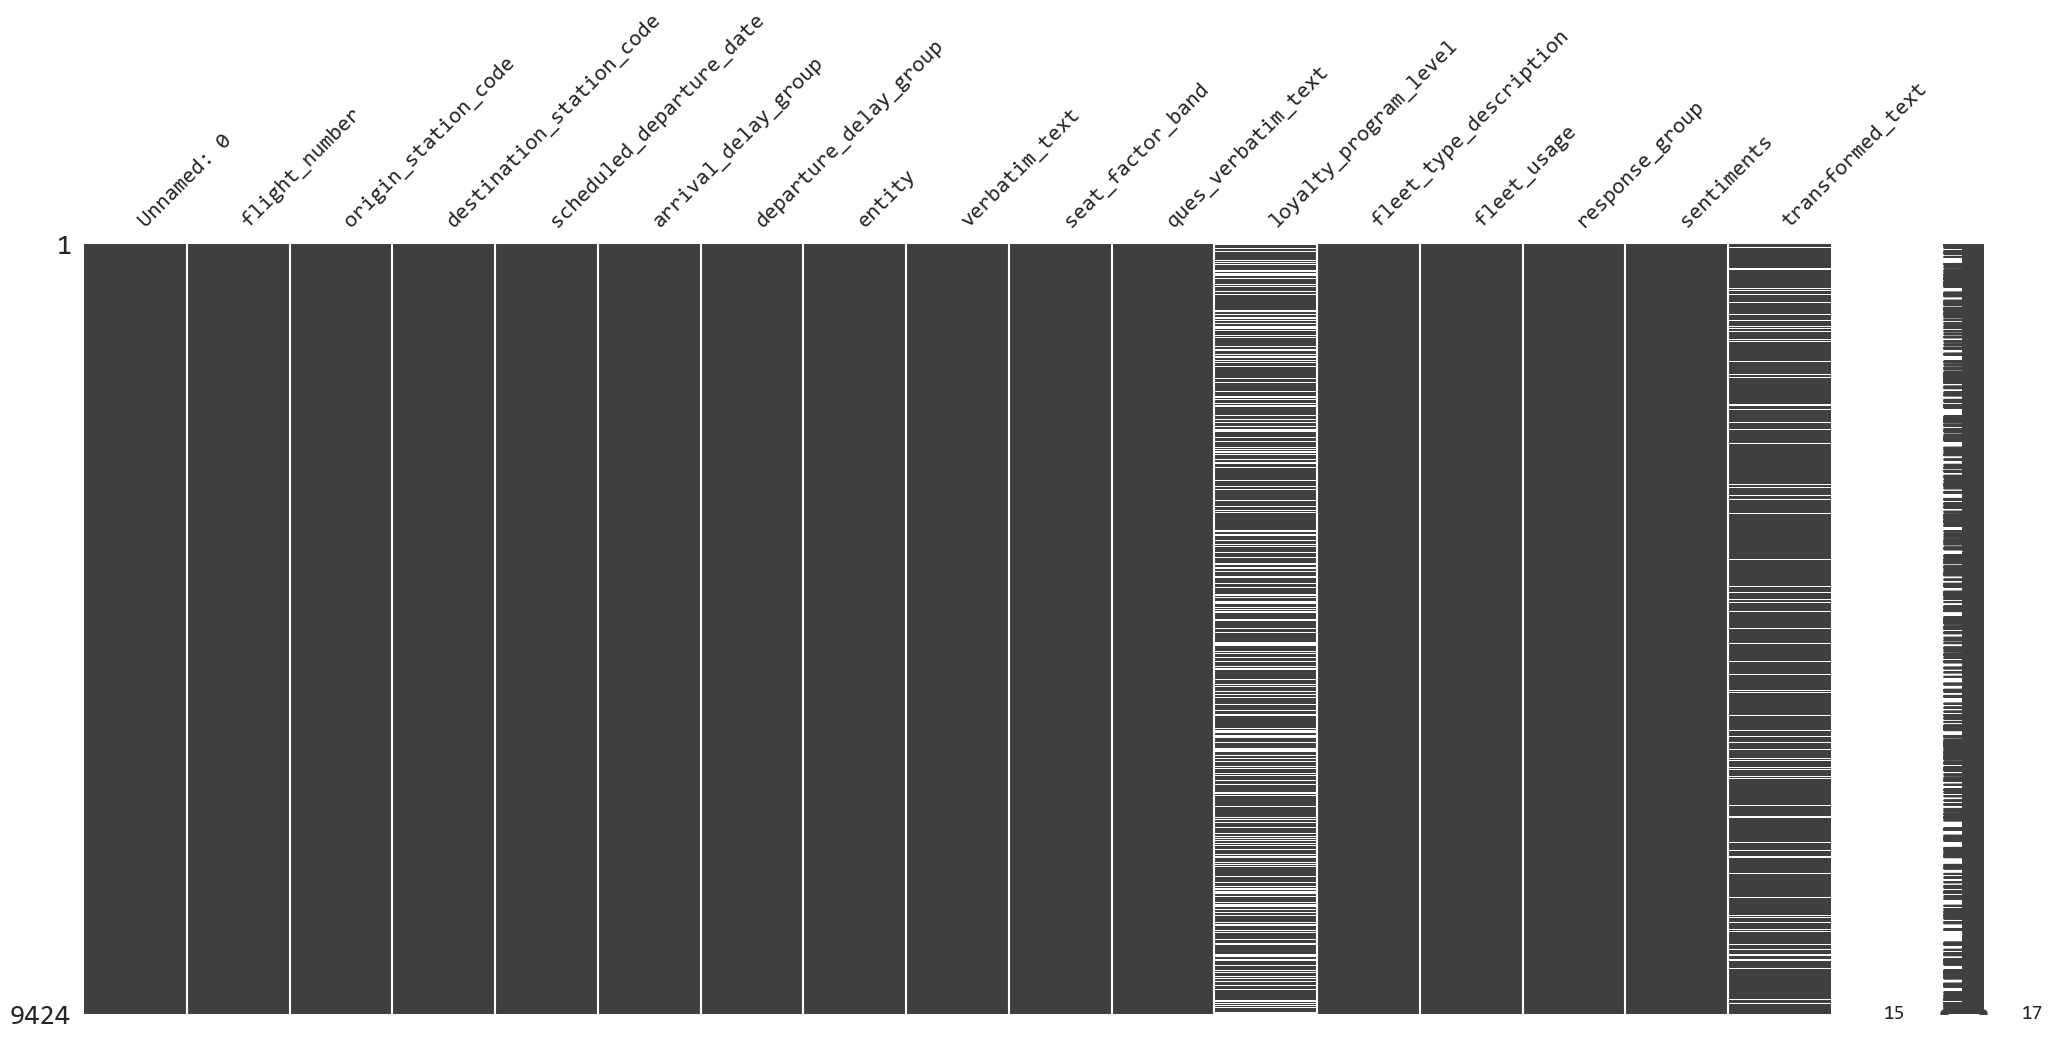

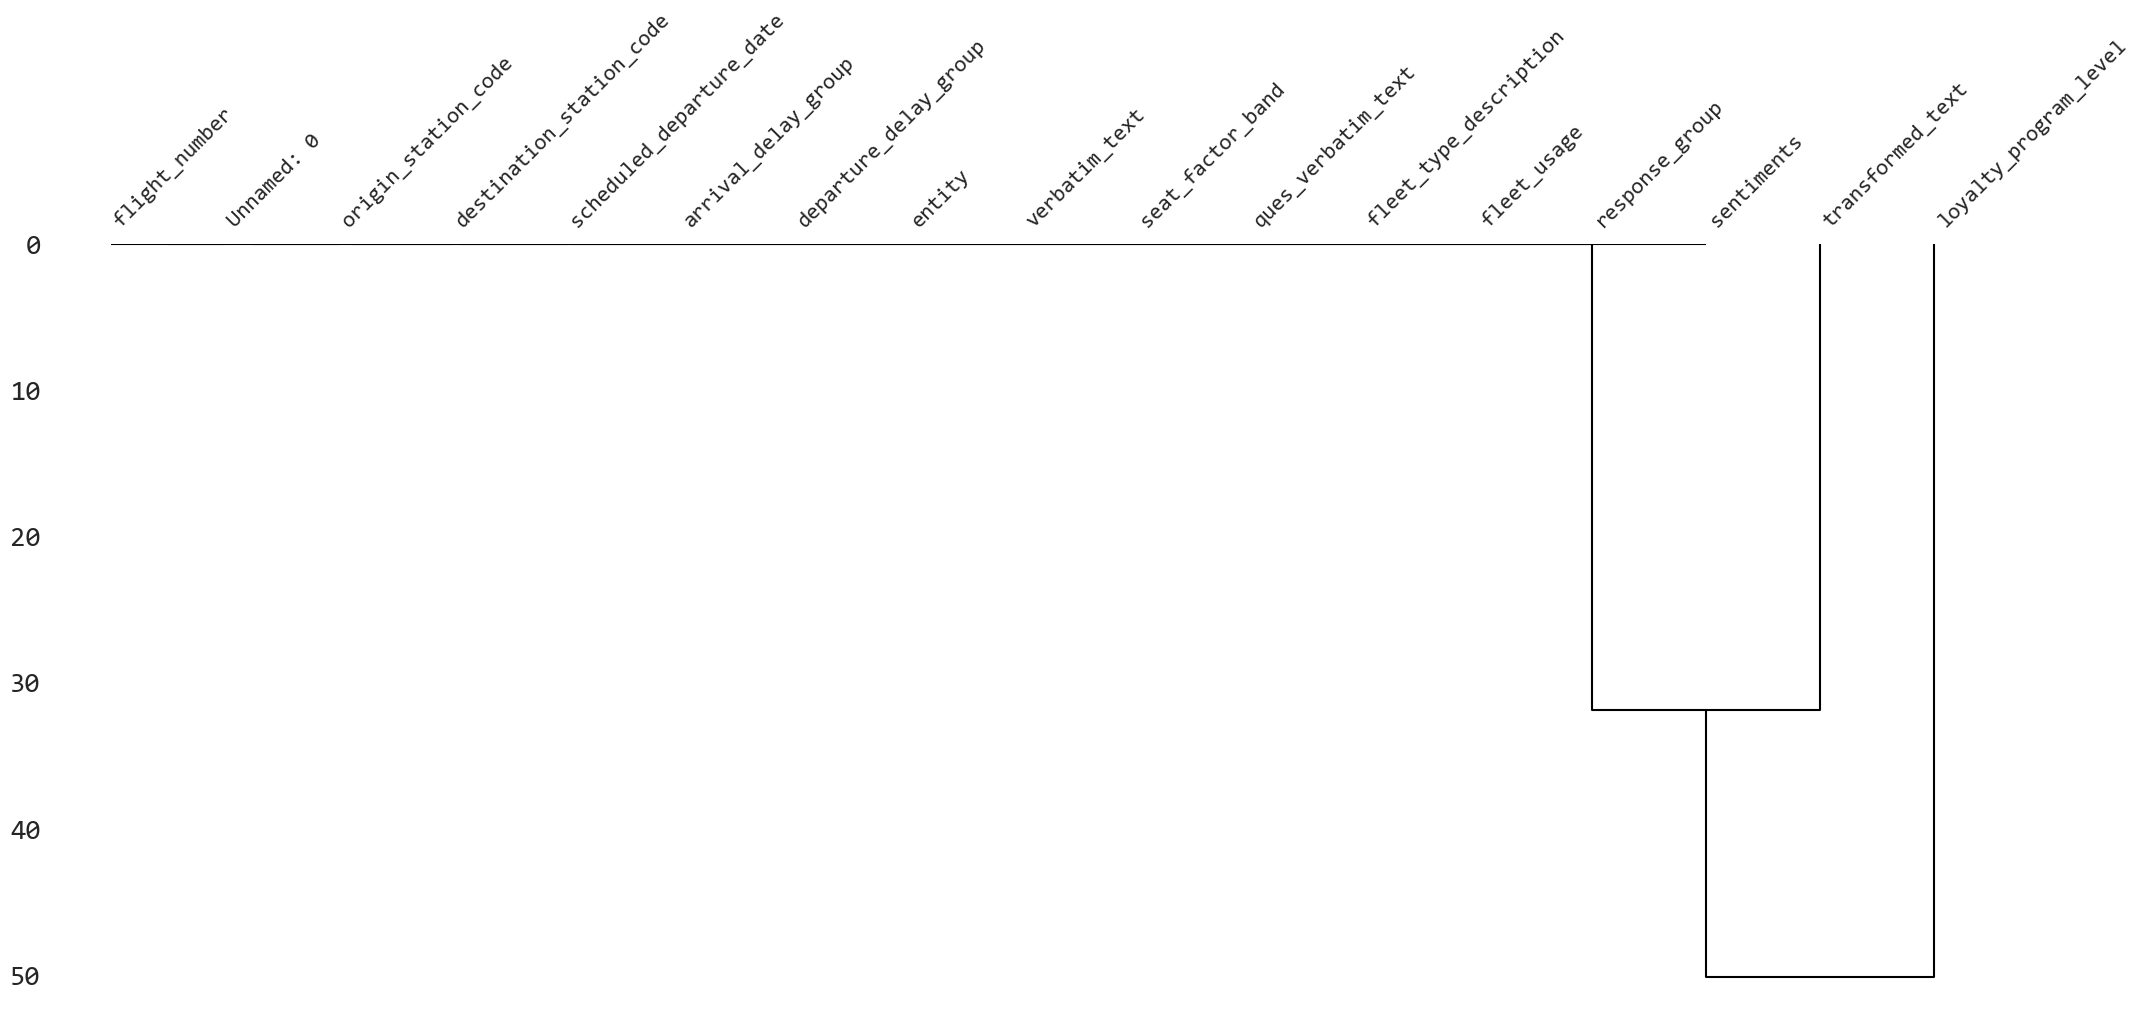

In [238]:
explore_na(comments_df)

- `loyalty_program_level` has a notable minority of missing values, should be inferrable from `response_group`.
- `transformed_text` inicates the result of an operation on `verbatim_text`, should be inferrable from it.

#### Comments Table Data Cleaning

In [239]:
comments_df.drop(columns=['Unnamed: 0', 'ques_verbatim_text'], inplace=True)
comments_df = comments_df[comments_df['loyalty_program_level'] != 'NBK']

- The unnamed column was dropped for being just a unique identifier, which is redundant to our needs.
- `ques_verbatim_text` was dropped for having the same value across all rows.
- The outler value between `loyalty_program_level` and `response_group` was dropped.

In [240]:
resp_vs_loyalty = pd.crosstab(comments_df['response_group'], comments_df['loyalty_program_level'], dropna=False)
display(resp_vs_loyalty)

comments_df['loyalty_program_level'].fillna('non-loyal', inplace=True)

loyalty_program_level,global services,non-elite,premier 1k,premier gold,premier platinum,premier silver,NaN
response_group,,,,,,,
member,140,4115,722,603,451,874,0
non-member,0,13,0,1,0,0,2504


C:\Users\Compumarts\AppData\Local\Temp\ipykernel_23932\1157576775.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comments_df['loyalty_program_level'].fillna('non-loyal', inplace=True)


- The assumed correlation between `response_group` and `loyalty_program_level` was investigated and a strongly possible relationship was found.
- Null values in `loyalty_program_level` are attributed to an actual lack of a loyalty level mostly due to lack of membership, so they were filled accordingly.

In [241]:
na_transtext = comments_df[comments_df['transformed_text'].isna()]
print("Null Transformed Texts:")
display(na_transtext[['verbatim_text']].head(5))

comments_df['transformed_text'].fillna('', inplace=True)

Null Transformed Texts:


,verbatim_text
11,no.
27,No.
42,no.
43,no.
44,No.


C:\Users\Compumarts\AppData\Local\Temp\ipykernel_23932\2060790783.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comments_df['transformed_text'].fillna('', inplace=True)


- Null values in `transformed_text` are attributed to an actual lack of a response, so they were filled to reflect that.

flight_number               0
origin_station_code         0
destination_station_code    0
scheduled_departure_date    0
arrival_delay_group         0
departure_delay_group       0
entity                      0
verbatim_text               0
seat_factor_band            0
loyalty_program_level       0
fleet_type_description      0
fleet_usage                 0
response_group              0
sentiments                  0
transformed_text            0
dtype: int64

<Axes: >

d:\Workspace\airline-booking\venv\Lib\site-packages\scipy\cluster\hierarchy.py:2950: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Axes: >

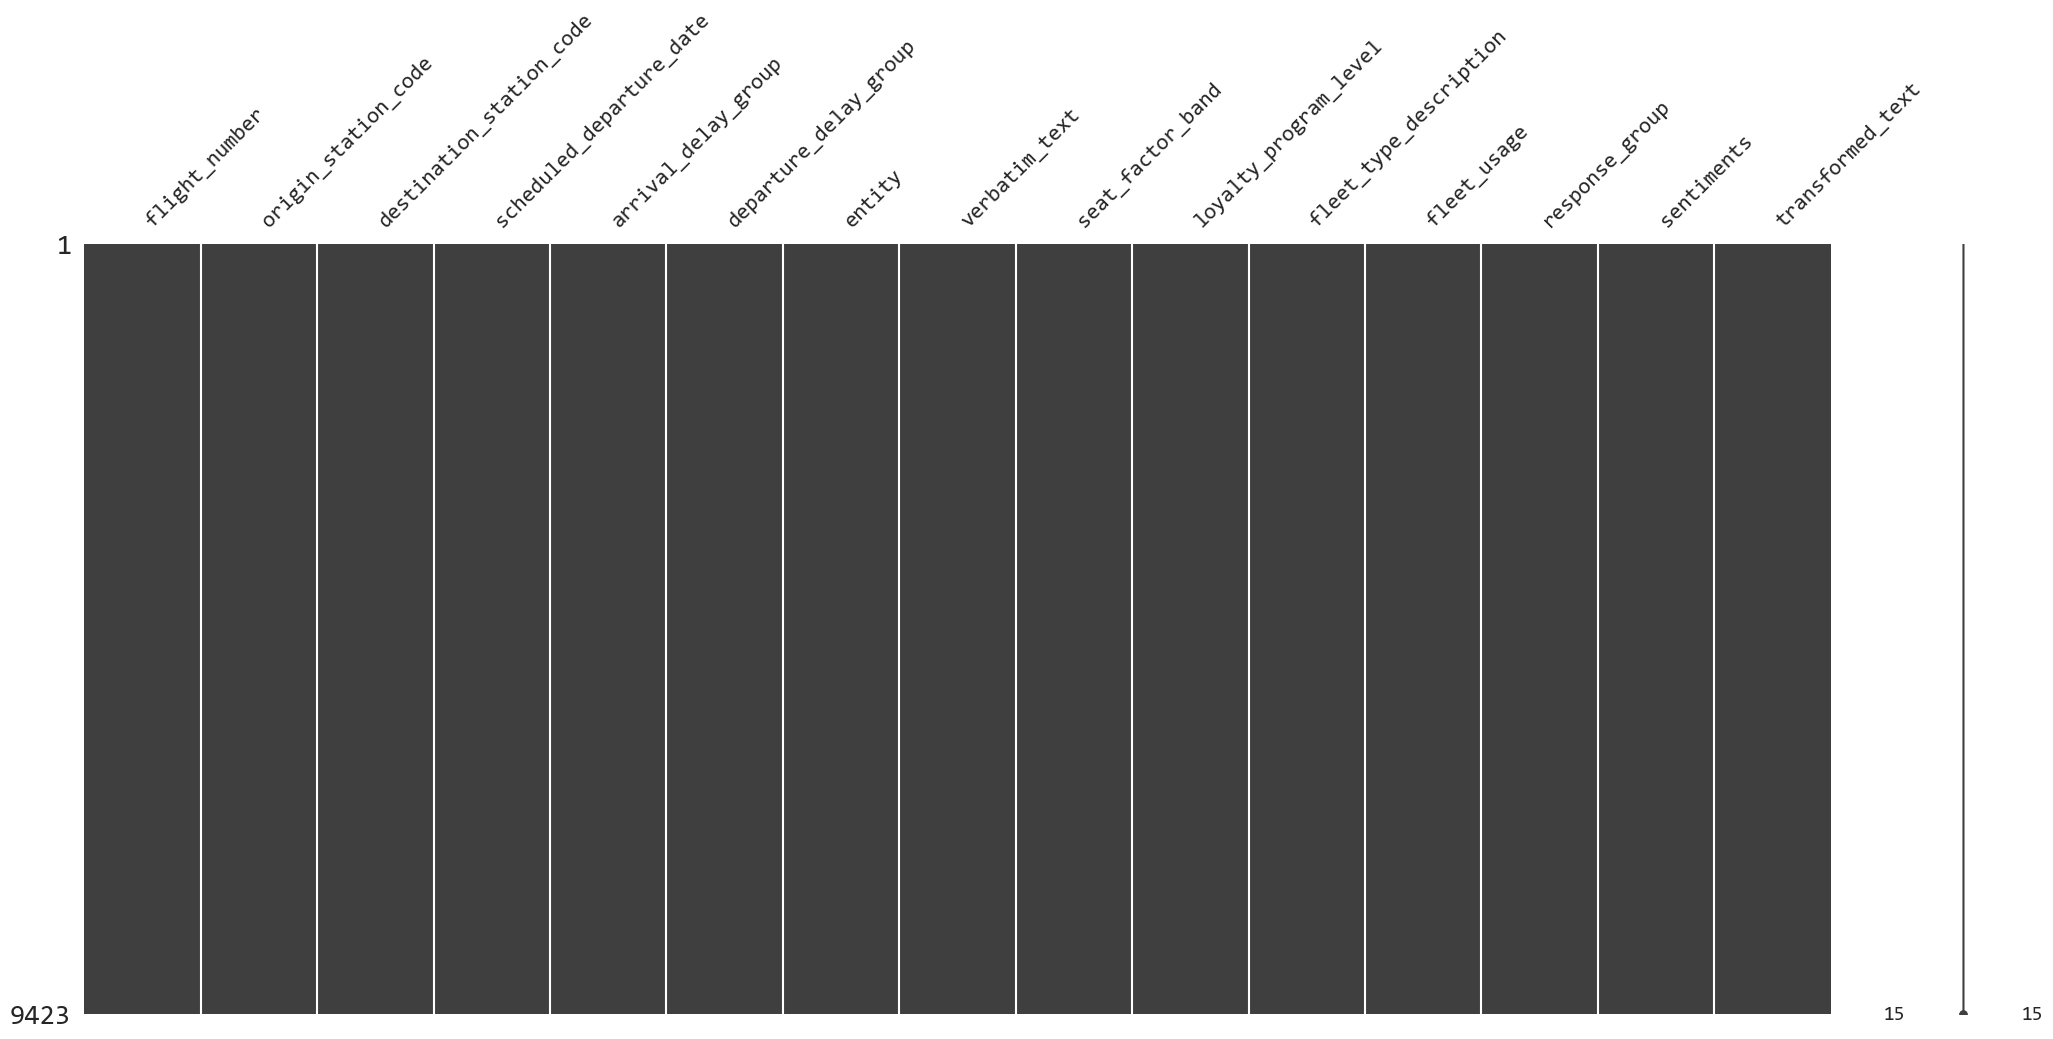

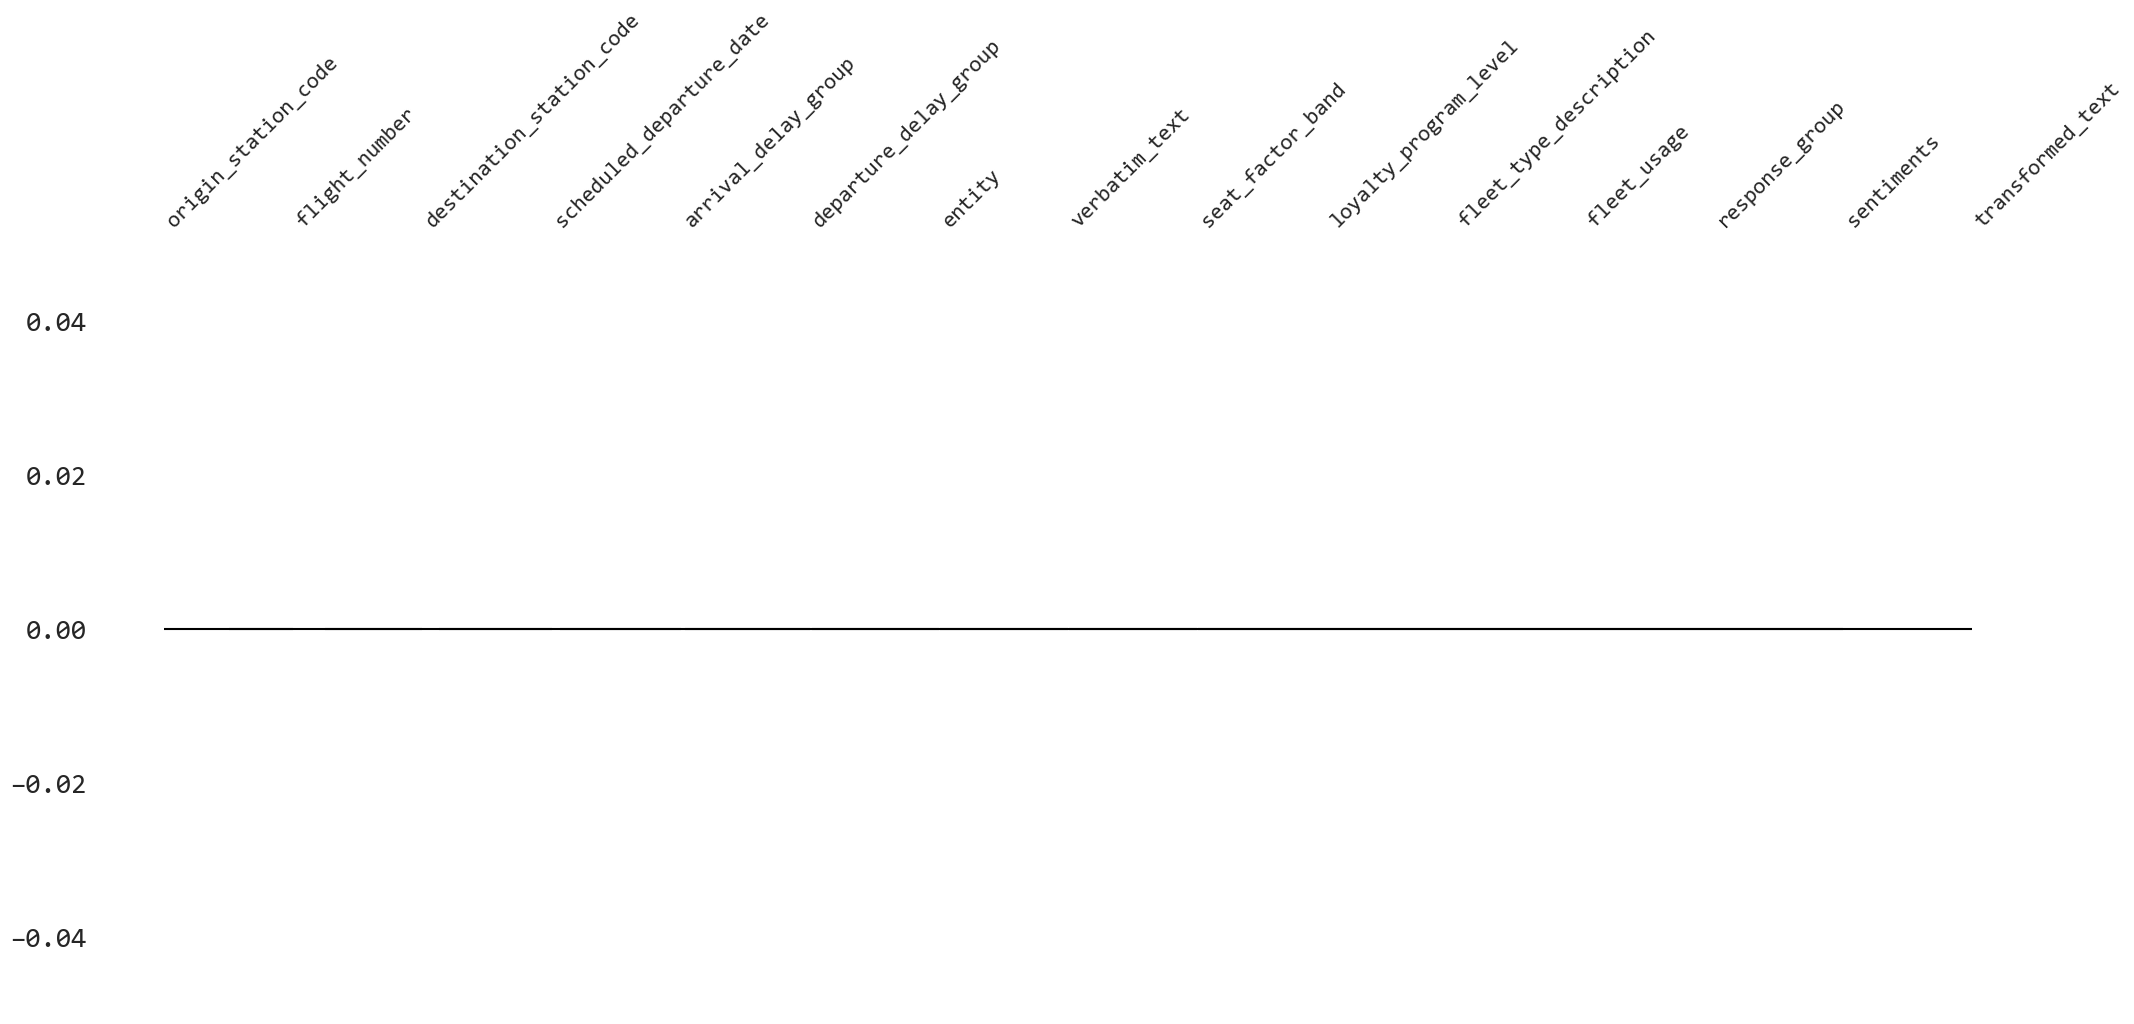

In [242]:
explore_na(comments_df)

In [243]:
# comments_df.to_csv('processed_dataset/customer_comments.csv', index=False)

### Bookings Table Data Processing

#### Bookings Table Data Exploration

In [244]:
bookings_df = pd.read_csv('raw_dataset/Passanger_booking_data.csv')

In [245]:
clean_text(reviews_df)
dedupe(bookings_df)

Number Of Dropped Duplicates: 719


In [246]:
display(bookings_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49283 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49283 non-null  int64  
 1   sales_channel          49283 non-null  object 
 2   trip_type              49283 non-null  object 
 3   purchase_lead          49283 non-null  int64  
 4   length_of_stay         49283 non-null  int64  
 5   flight_hour            49283 non-null  int64  
 6   flight_day             49283 non-null  object 
 7   route                  49283 non-null  object 
 8   booking_origin         49283 non-null  object 
 9   wants_extra_baggage    49283 non-null  int64  
 10  wants_preferred_seat   49283 non-null  int64  
 11  wants_in_flight_meals  49283 non-null  int64  
 12  flight_duration        49283 non-null  float64
 13  booking_complete       49283 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


None

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000,49283.000000
mean,1.590204,84.723393,23.054197,9.070613,0.668222,0.295639,0.426638,7.279937,0.149991
std,1.016540,90.409389,33.831644,5.413007,0.470856,0.456334,0.494594,1.496381,0.357066
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.000000,5.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.000000,9.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.000000,13.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.000000,23.000000,1.000000,1.000000,1.000000,9.500000,1.000000


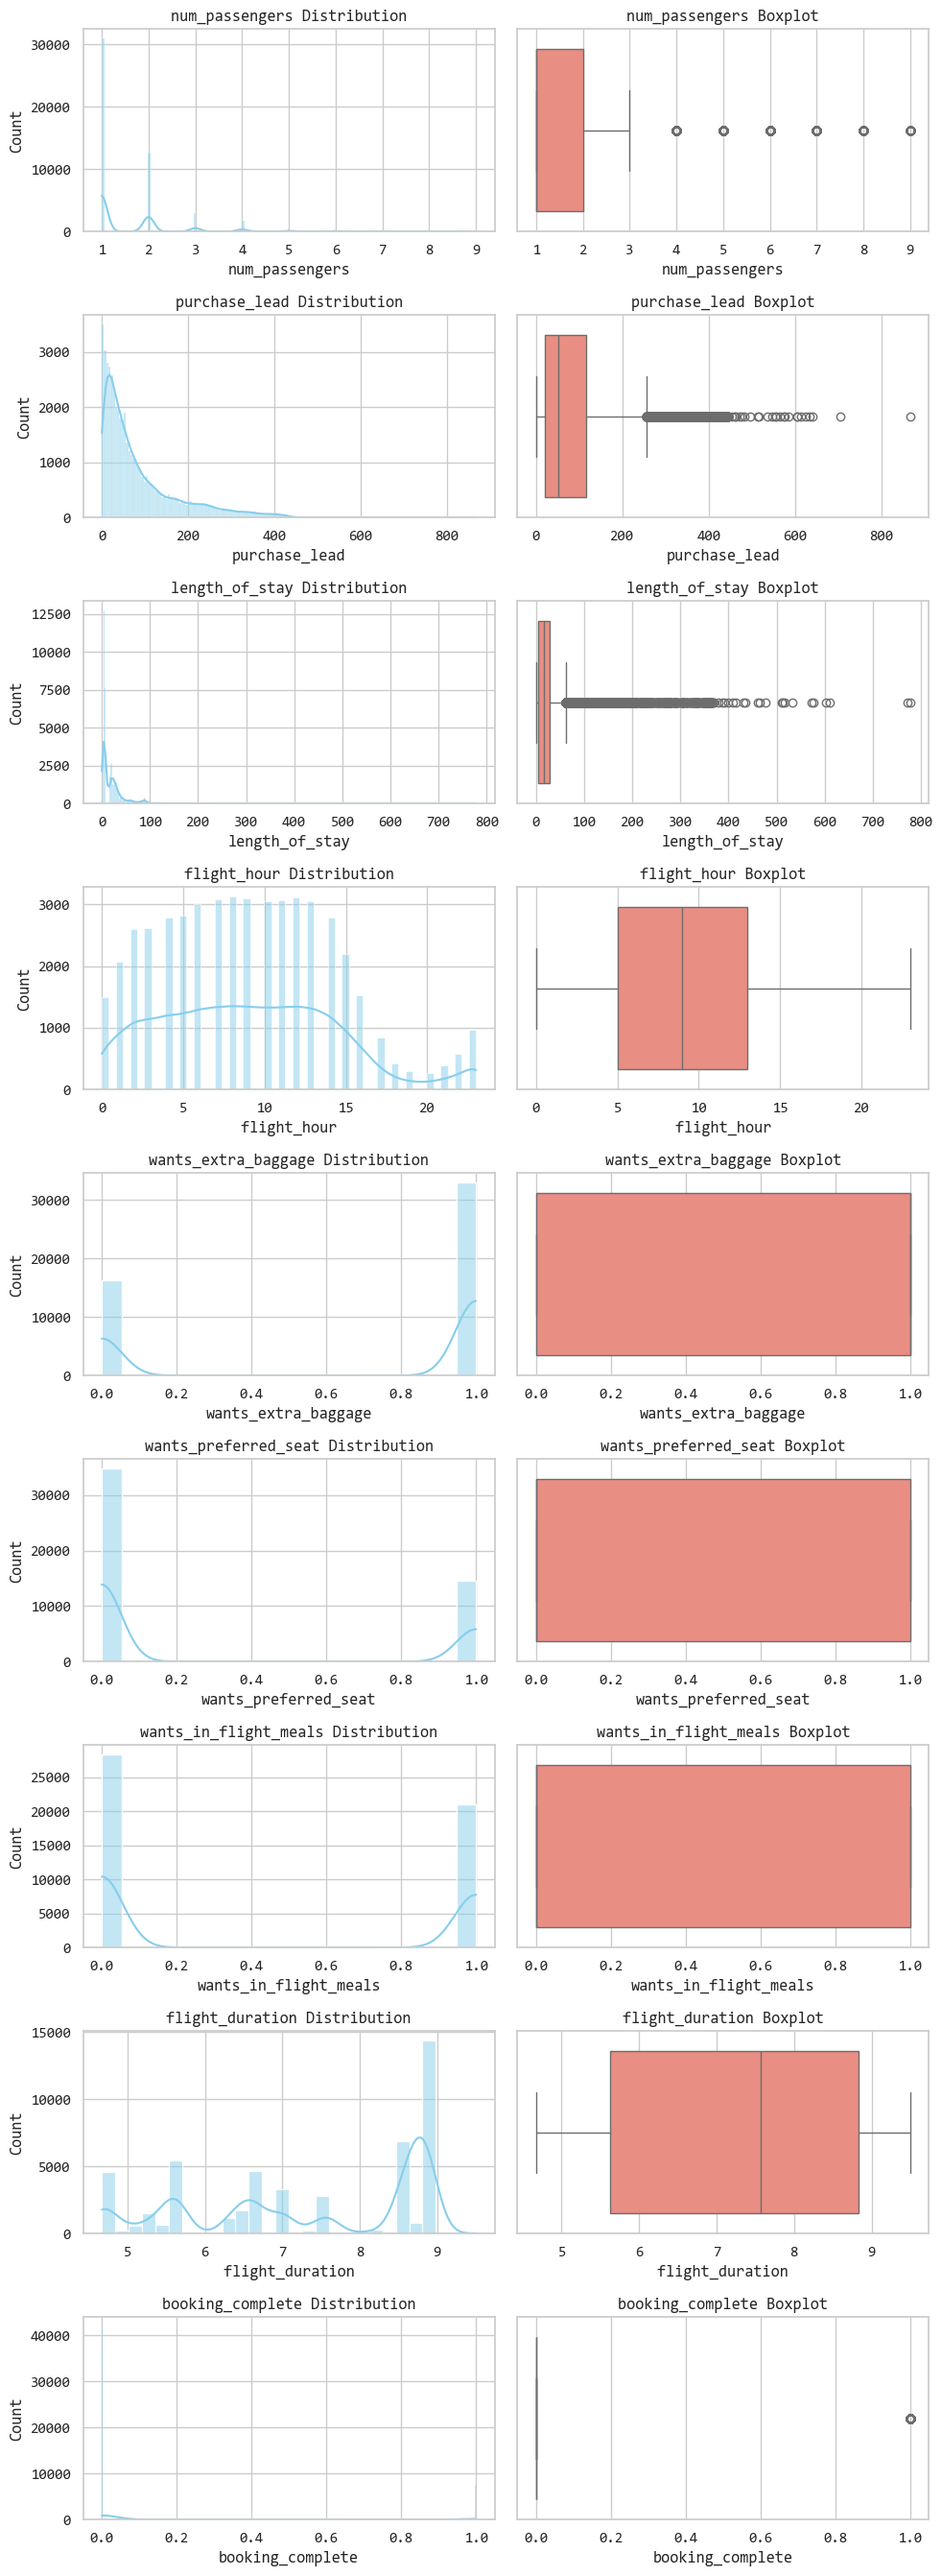

None

<Axes: >

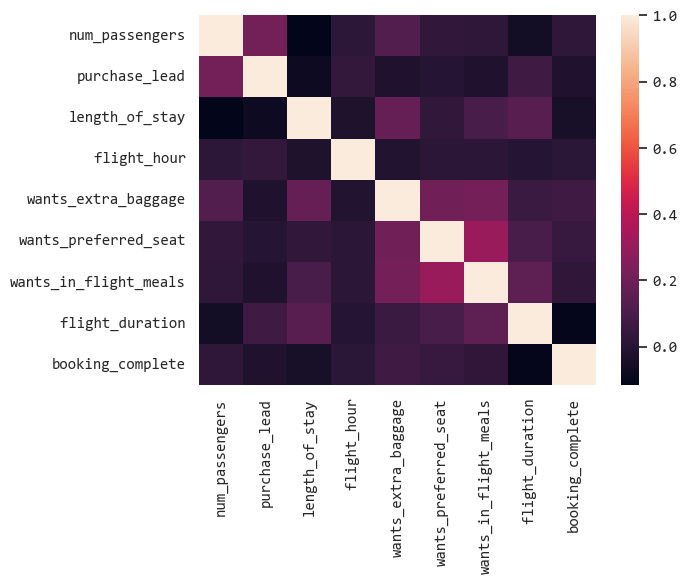

In [247]:
explore_numeric_cols(bookings_df)

In [248]:
explore_object_cols(bookings_df)

,sales_channel,trip_type,flight_day,route,booking_origin
count,49283,49283,49283,49283,49283
unique,2,3,7,799,104
top,Internet,RoundTrip,Mon,AKLKUL,Australia
freq,43918,48780,7988,2620,17692


================= sales_channel ==================
Internet                                 43918
Mobile                                   5365

=================== trip_type ====================
RoundTrip                                48780
OneWay                                   386
CircleTrip                               117

=================== flight_day ===================
Mon                                      7988
Wed                                      7563
Tue                                      7559
Thu                                      7323
Fri                                      6685
Sun                                      6442
Sat                                      5723

===================== route ======================
AKLKUL                                   2620
PENTPE                                   912
MELSGN                                   833
ICNSIN                                   793
DMKKIX                                   729
ICNSYD         

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

<Axes: >

d:\Workspace\airline-booking\venv\Lib\site-packages\scipy\cluster\hierarchy.py:2950: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Axes: >

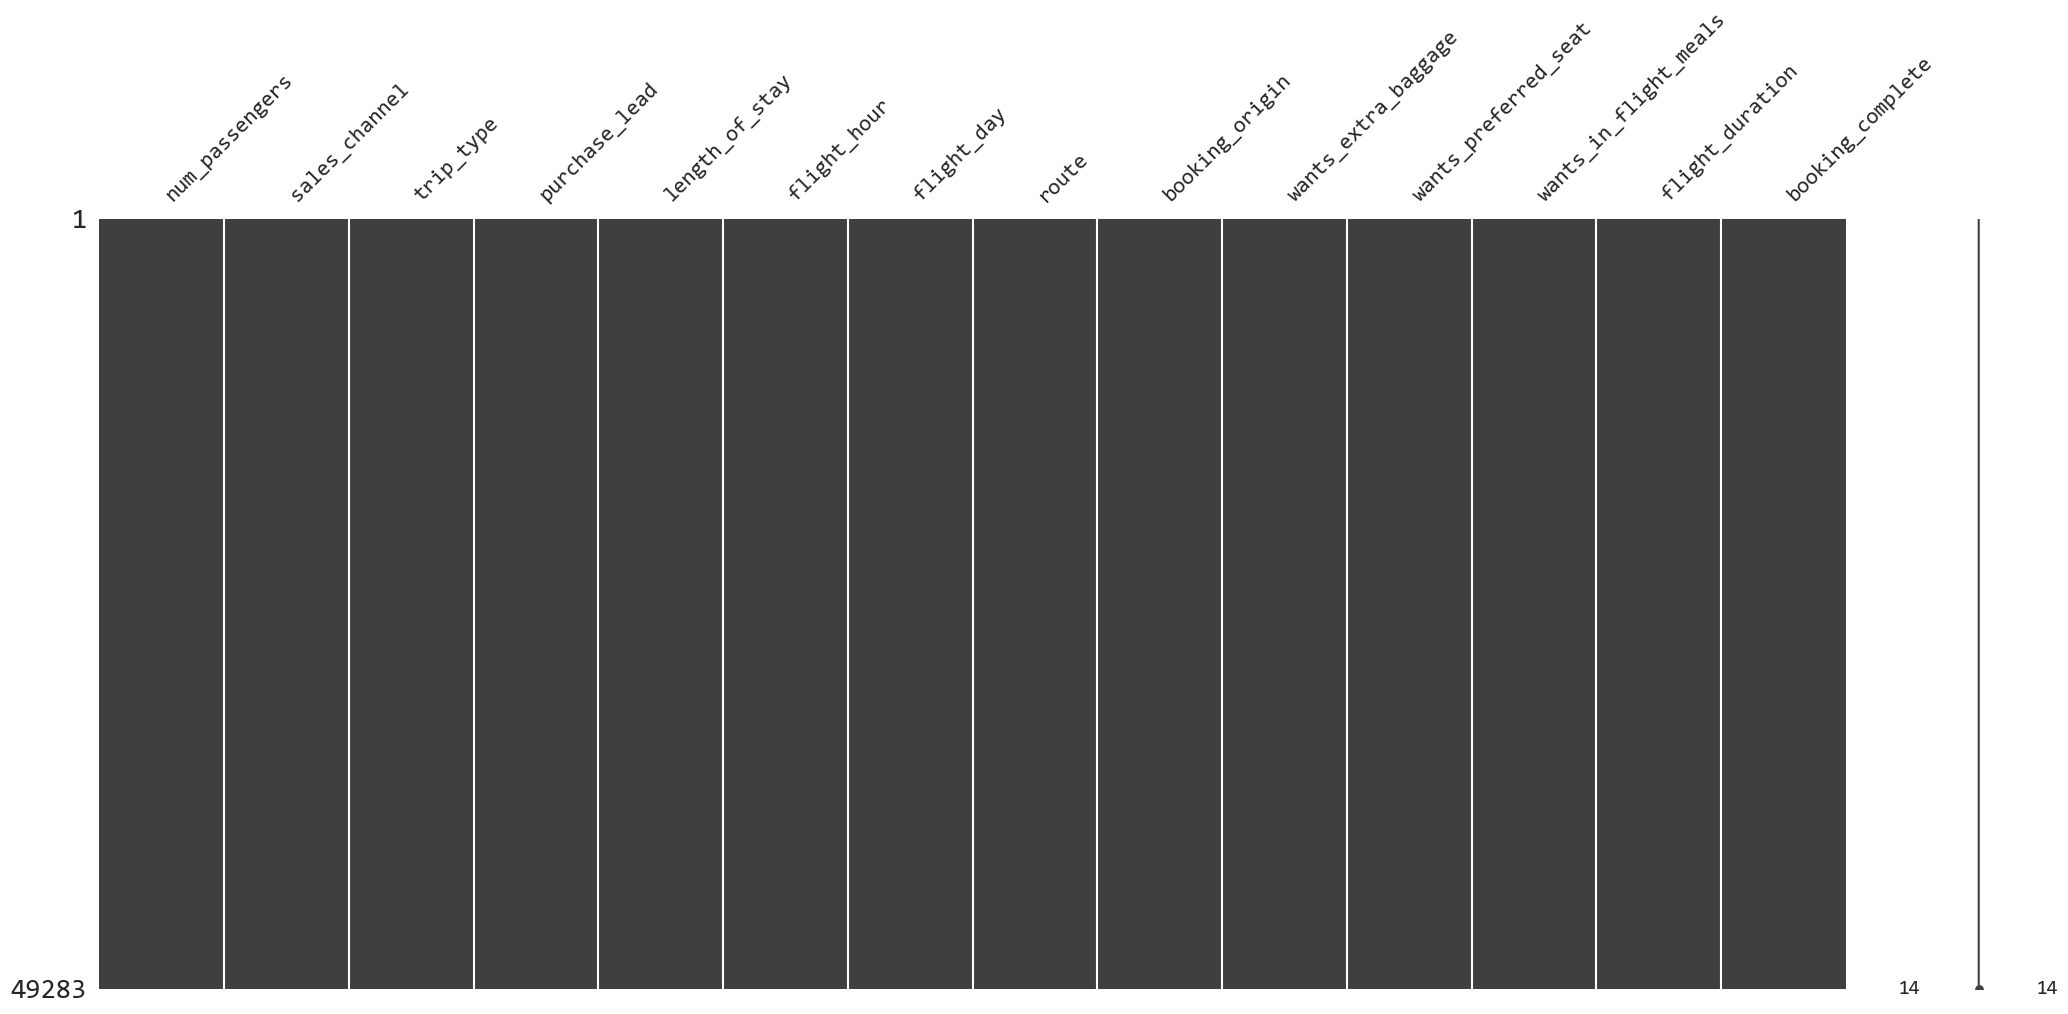

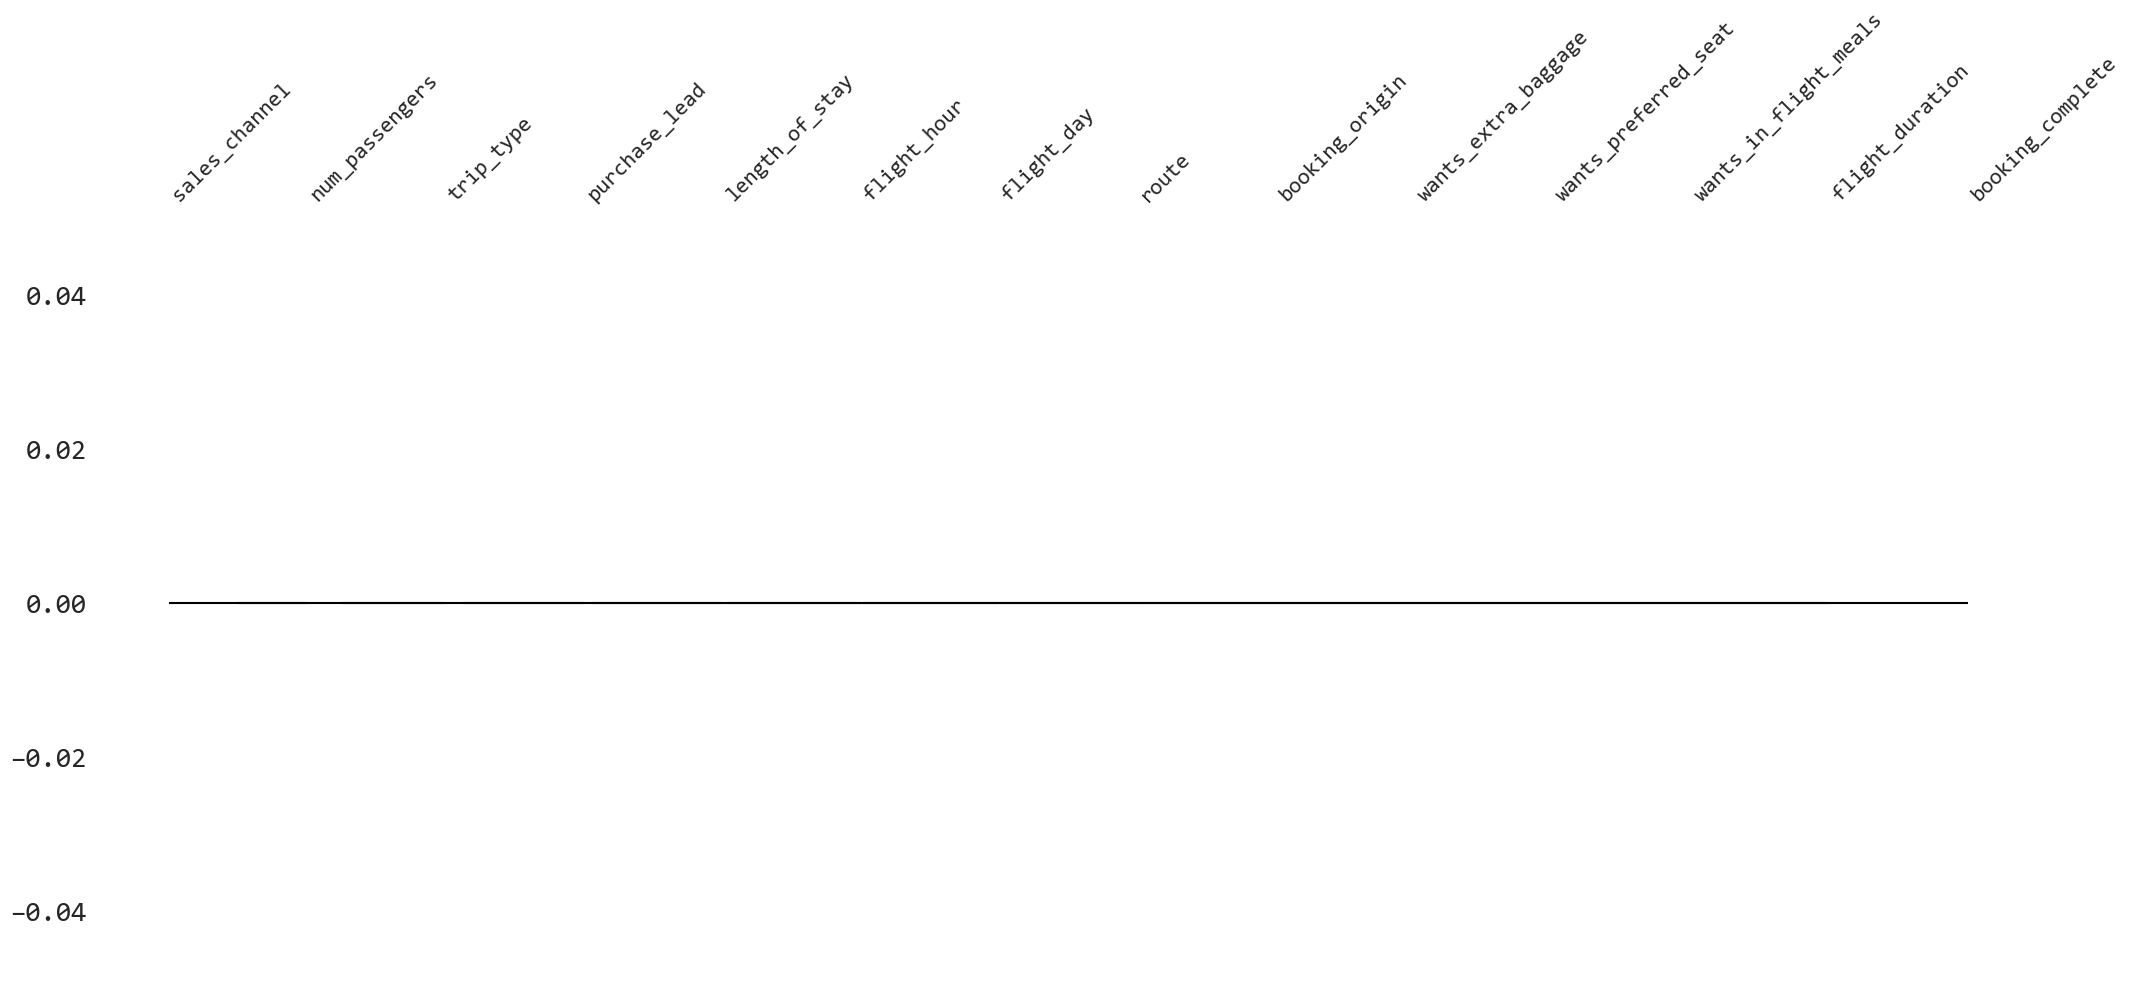

In [249]:
explore_na(bookings_df)

- Data is clean and sound, no fillings or droppings were made. Only deduplications.

In [250]:
# bookings_df.to_csv('processed_dataset/passenger_bookings.csv', index=False)

## Data Visualization

### Reviews Table Data Visualization

In [251]:
reviews_df = pd.read_csv('processed_dataset/airline_reviews.csv')

<Axes: ylabel='route'>

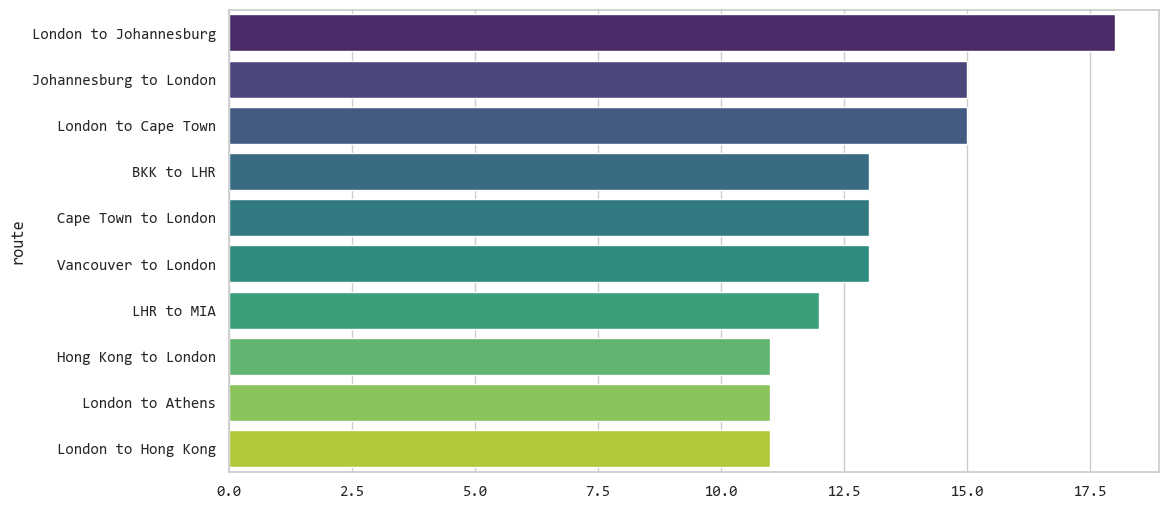

In [252]:
top_routes = reviews_df['route'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
display(sns.barplot(x=top_routes.values, y=top_routes.index, hue=top_routes.index, palette='viridis'))

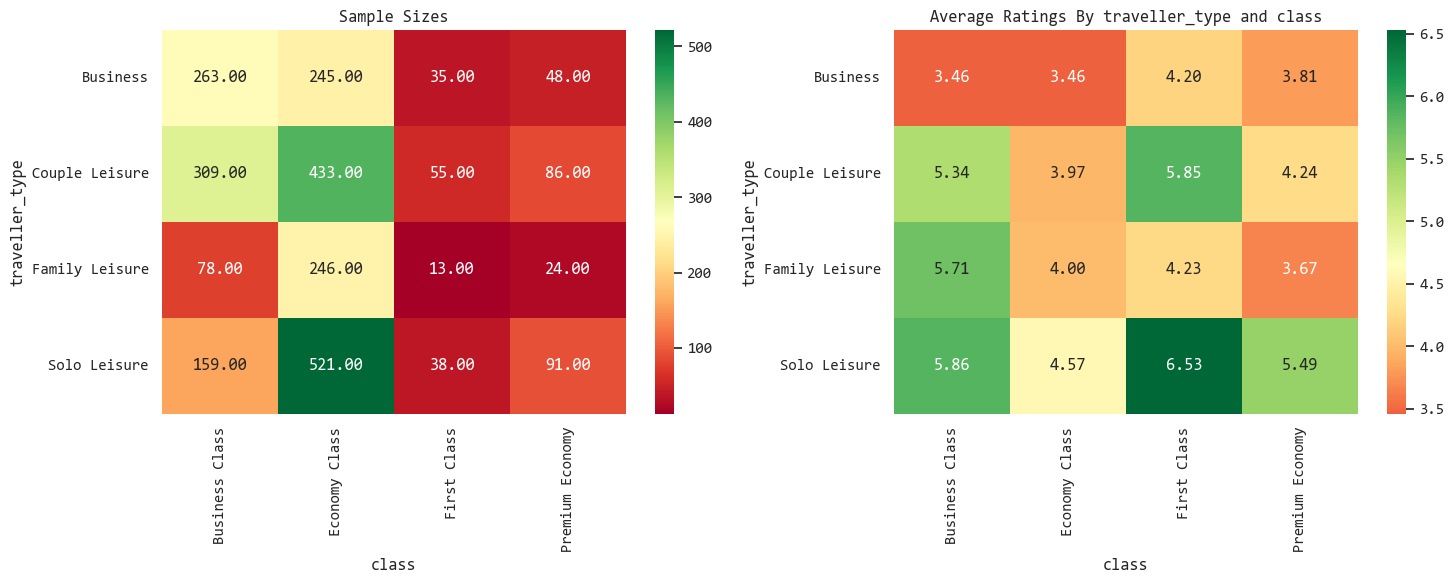

None

In [253]:
pivot_ratings = reviews_df.pivot_table(index='traveller_type', columns='class', values='rating', aggfunc=['mean', 'count'])

figure, (samples, ratings) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(pivot_ratings['count'], annot=True, fmt='.2f', cmap='RdYlGn', ax=samples)
samples.set_title('Sample Sizes')

sns.heatmap(pivot_ratings['mean'], annot=True, fmt='.2f', cmap='RdYlGn', center=pivot_ratings['mean'].mean().mean(), ax=ratings)
ratings.set_title('Average Ratings By traveller_type and class')

plt.tight_layout()
display(plt.show())

### Bookings Table Data Visualization

In [254]:
bookings_df = pd.read_csv('processed_dataset/passenger_bookings.csv')

<Axes: ylabel='route'>

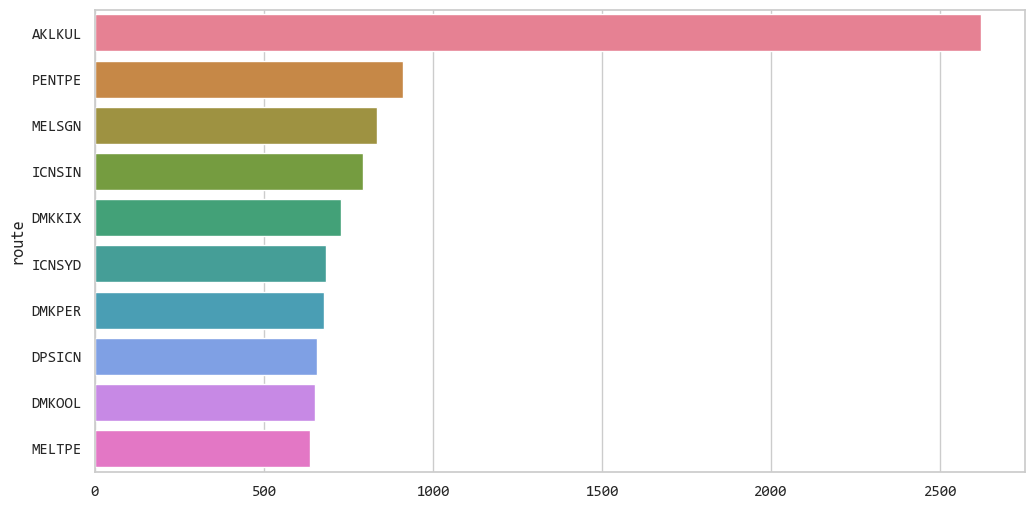

In [255]:
top_routes = bookings_df['route'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
display(sns.barplot(x=top_routes.values, y=top_routes.index, hue=top_routes.index))

<Axes: xlabel='flight_hour'>

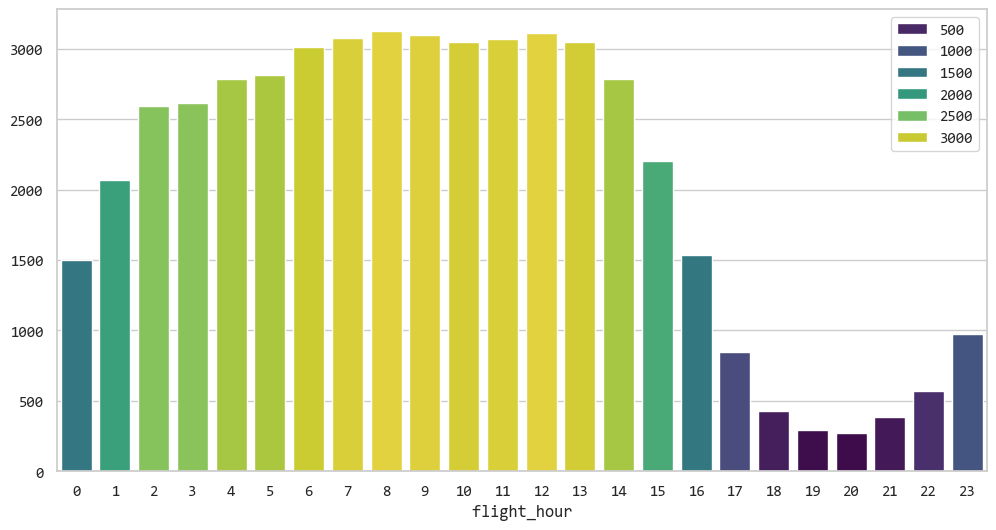

In [256]:
hours_dist = bookings_df['flight_hour'].value_counts()

plt.figure(figsize=(12, 6))
display(sns.barplot(x=hours_dist.index, y=hours_dist.values, hue=hours_dist.values, palette='viridis'))

## Prediction Model

### Feature Selection

In [257]:
reviews_df = pd.read_csv('processed_dataset/airline_reviews.csv')

In [258]:
X = reviews_df[['traveller_type', 'class', 'verified', 'sentiment']]
y = (reviews_df['rating'] >= 5).rename('satisfied')

### Feature Preparation

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

background = shap.sample(X_train, 100, random_state=42)

### Model Building

#### Model #01

##### Model #01 Architecture

In [260]:
model_01 = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

display(model_01.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289 (1.13 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

None

In [261]:
model_01.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy',
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall')])

In [262]:
history_01 = model_01.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
])

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6915 - loss: 0.6213 - precision: 0.6899 - recall: 0.4658 - val_accuracy: 0.6785 - val_loss: 0.6028 - val_precision: 0.7115 - val_recall: 0.4111
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7400 - loss: 0.5566 - precision: 0.7569 - recall: 0.5499 - val_accuracy: 0.7518 - val_loss: 0.5533 - val_precision: 0.7301 - val_recall: 0.6611
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.5058 - precision: 0.7479 - recall: 0.7650 - val_accuracy: 0.7730 - val_loss: 0.5156 - val_precision: 0.7039 - val_recall: 0.8056
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4731 - precision: 0.7259 - recall: 0.8262 - val_accuracy: 0.7754 - val_loss: 0.4950 - val_precision: 0.7033 - val_recall: 0.8167
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4580 - precision: 0.7291 - recall: 0.8319 - val_accuracy: 0.7778 - val_loss: 0.4862 - val

##### Model #01 Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Loss: 0.482835054397583
Accuracy: 0.7977315783500671
Precision: 0.7832699418067932
Recall: 0.8046875


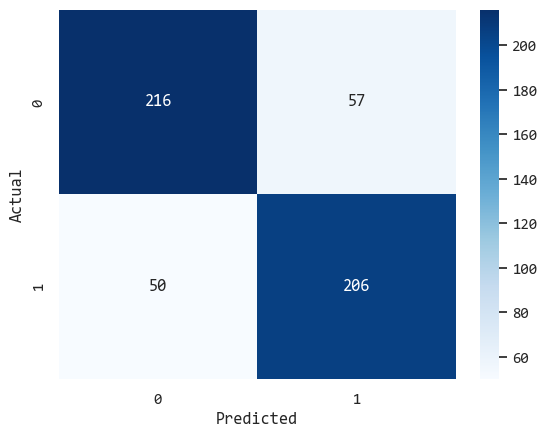

None

              precision    recall  f1-score   support

       False       0.81      0.79      0.80       273
        True       0.78      0.80      0.79       256

    accuracy                           0.80       529
   macro avg       0.80      0.80      0.80       529
weighted avg       0.80      0.80      0.80       529



In [265]:
evaluate_metrics(model_01, X_test, y_test)

##### Model #01 Explaination

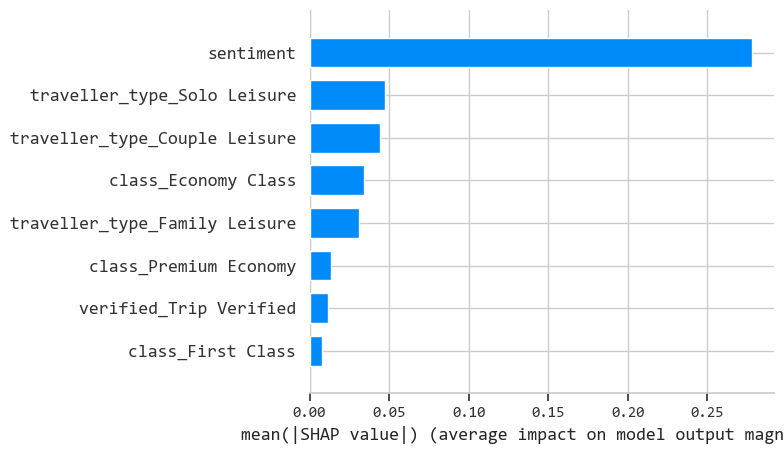

None

In [276]:
explainer_01 = shap.Explainer(model_01, background)
shap_01 = explainer_01(X_test)

display(shap.summary_plot(shap_01.values, X_test, feature_names=X_encoded.columns, plot_type='bar'))

In [ ]:
shap.plots.force(shap_01[0], feature_names=X_encoded.columns)

In [299]:
def predict_proba(X):
    preds = model_01.predict(X)
    return np.hstack((1 - preds, preds))

explainer = LimeTabularExplainer(
    training_data=X_train,  # encoded features
    feature_names=X_encoded.columns, # keep original col names if you renamed
    class_names=["K","No"],        # adjust for your task
    mode="classification"
)

exp = explainer.explain_instance(
    X_test[1],
    predict_proba,
    num_features=10
)

for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

exp.show_in_notebook()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
sentiment > 1.02: 0.4507
traveller_type_Family Leisure <= -0.40: -0.1439
class_First Class <= -0.24: 0.1363
-0.66 < traveller_type_Solo Leisure <= 1.51: 0.0531
traveller_type_Couple Leisure <= -0.71: -0.0386
-1.10 < class_Economy Class <= 0.91: -0.0256
-1.34 < verified_Trip Verified <= 0.75: -0.0095
class_Premium Economy <= -0.32: -0.0013


ImportError: cannot import name 'display' from 'IPython.core.display' (d:\Workspace\airline-booking\venv\Lib\site-packages\IPython\core\display.py)